**Source:** https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# common imports
import pandas as pd
import numpy as np
from collections import Counter
import re

# language processing imports
import nltk
from gensim.corpora import Dictionary
#preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set() # defines the style of the plots to be seaborn style

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import os
dir_path = '/content/drive/My Drive/LDA_Word2Vec/'

train_data = pd.read_csv(os.path.join(dir_path, 'train.csv'))
print(train_data.shape)
train_data.head(3)

(19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP


# 1) Feature Inspection

- How many documnets are there per writer?<br>
- What is the length of the documents?<br>
- What are (in)frequent words?

**Authors (LABELS):**<br>
`EAP`: Edgar Allan Poe<br>
`HPL`: HP Lovecraft<br>
`MWS`: Mary Wollstonecraft Shelley

In [6]:
# check if there's missing data
train_data.isnull().sum()

id        0
text      0
author    0
dtype: int64

## Inspect author variable

In [7]:
train_data.author.value_counts().index

Index(['EAP', 'MWS', 'HPL'], dtype='object')

In [8]:
train_data.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

[<matplotlib.patches.Rectangle object at 0x7f79056430b8>, <matplotlib.patches.Rectangle object at 0x7f7905633dd8>, <matplotlib.patches.Rectangle object at 0x7f79056436a0>]


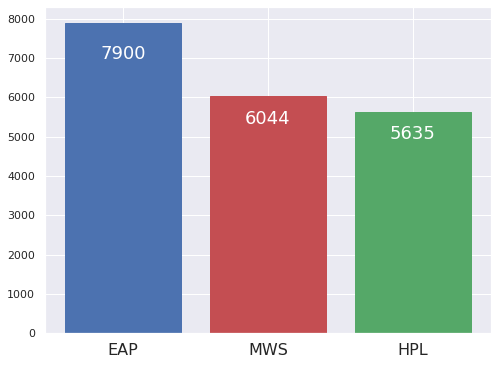

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

author_vc = train_data.author.value_counts()

ax.bar(range(3), author_vc)
ax.set_xticks(range(3))
ax.set_xticklabels(author_vc.index, fontsize=16)

print(ax.patches)
for rect, c, value in zip(ax.patches, ['b', 'r', 'g'], author_vc.values):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc+width/2, 0.9*height, value, ha='center', va='center', fontsize=18, color='white')
    
    

## Inspect text variable

In [26]:
document_lengths = np.array(list(map(len, train_data.text.str.split(' '))))

print(f"The average number of words in a documents is : {round(np.mean(document_lengths), 2)}")
print(f"The minimum number of words in a documents is : {min(document_lengths)}")
print(f"The maximum number of words in a documents is : {max(document_lengths)}")


The average number of words in a documents is : 26.73
The minimum number of words in a documents is : 2
The maximum number of words in a documents is : 861


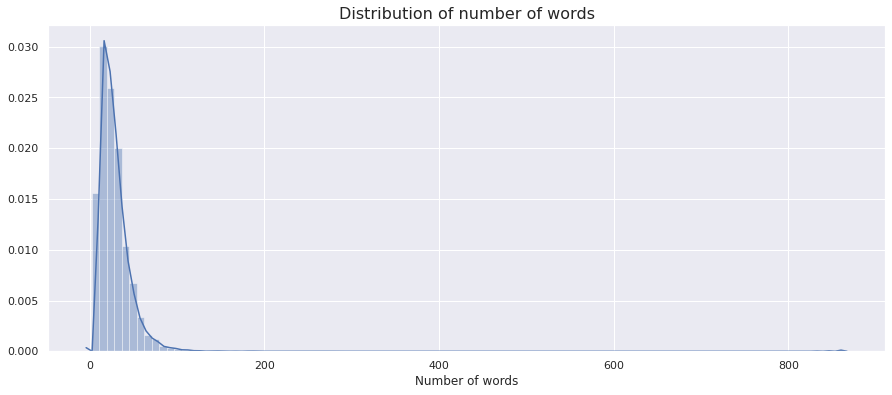

In [27]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=100, ax=ax)

In [28]:
print(f"There are {sum(document_lengths > 150)} with over 150 words")
print(f"There are {sum(document_lengths > 100)} with over 100 words")

shorter_documents = document_lengths[document_lengths <= 150]

There are 16 with over 150 words
There are 88 with over 100 words


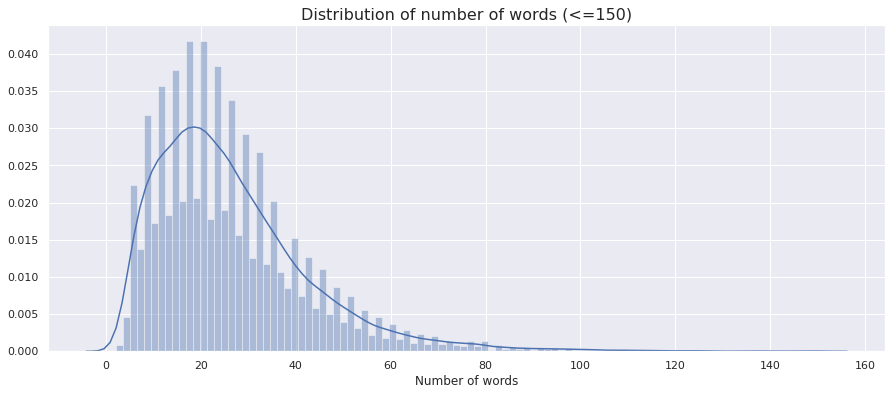

In [29]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.set_title("Distribution of number of words (<=150)", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=100, ax=ax)

In [30]:
print(f"Number of short documents with <= 5 words: {sum(document_lengths <= 5)}")


Number of short documents with <= 5 words: 452


In [31]:
train_data[document_lengths == 2]

,id,text,author,document_sentences
6936,id22015,"""piquant expressions.",EAP,"[""piquant expressions, ]"
9250,id23640,"""extraordinary murders.",EAP,"[""extraordinary murders, ]"
18064,id05139,shakespeare's sonnets.,MWS,"[shakespeare's sonnets, ]"
18127,id20376,shakspeare's sonnets.,MWS,"[shakspeare's sonnets, ]"


In [32]:
train_data[document_lengths == 3]

,id,text,author,document_sentences
2403,id04385,"yours everlastingly, pundita.",EAP,"[yours everlastingly, pundita, ]"
2460,id04068,distinguished several words.,EAP,"[distinguished several words, ]"
2888,id13751,everyone loved elizabeth.,MWS,"[everyone loved elizabeth, ]"
3076,id21984,this thought creates.,EAP,"[this thought creates, ]"
4016,id17846,the uproar increases.,EAP,"[the uproar increases, ]"
4961,id17197,""" odenheimer, restaurateur.",EAP,"["" odenheimer, restaurateur, ]"
6394,id21456,idris had disappeared.,MWS,"[idris had disappeared, ]"
6418,id27928,"""sunday, the seventh.",EAP,"[""sunday, the seventh, ]"
8652,id26614,cats they caterwauled.,EAP,"[cats they caterwauled, ]"
8764,id16503,he dislikes children.,EAP,"[he dislikes children, ]"


# 2) Feature creation

## Text cleansing

   1. **Tokenize the text**; split sentences in (good) words. Thus watch out for punctuation.<br>
   2. **Remove words that mean little**; these are usually words that occur very frequently or words that occur very infrequently. Also, punctuation can be removed, but perhaps you'd like to keep some punctuation in, like exclamation marks or question marks since maybe one writer uses them more than others. 
   3. **Stemming**; this basically means joining words that mean the same. Take for example the words running and runs, the stem of both words is run. Thus with stemming you'd group these words together and give them the same meaning for the model.
   4. **Vectorize words**; since we can't input plain words into a model and expect it to learn from it, we have to vectorize the words. This basically means create unit vectors for all words.
   
   For LDA you'd like to perform all four steps. However, for w2v you'd only want to tokenize and remove some punctuation. The w2v model can determine by itself what words are important and what are not, but we'll get back to that later on.

## 2.1) Tokenize the text

I noticed there's some non-ascii characters present. I want to simply filter them out. For **LDA I want to completely remove these words** since it's highly likely the words with invalid characters appear only once and therefor don't have much value for the topics anyway.

**For word2vec I want to keep the order and the number of words per sentence** the same; therefor I will **replace these words with a random word 'qwerty'**. Why the number of words and the order is important, will be clear later on when we discuss the model.

Also, the input for the model will be sentences and that's why I will use '.' as the delimiter for sentences.

![ASCII Table](https://i.stack.imgur.com/iCOov.gif)

In [33]:
# find and remove non-ascii words
# I stored our special word in a variable for later use

our_special_word = 'qwerty'

def remove_ascii_words(df):
    """
    removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'text'].split(' '):
            if any([ord(character) > 127 for character in word]):
                print(i, word)
                non_ascii_words.append(word)
                df.loc[i, 'text'] = df.loc[i, 'text'].replace(word, our_special_word)
    return non_ascii_words

non_ascii_words = remove_ascii_words(train_data)

print("Replaced {} words with characters with an ordinal > 127 in the train data.".format(
    len(non_ascii_words)))

Replaced 0 words with characters with an ordinal > 127 in the train data.


In [34]:
train_data.loc[101].text

'"but, my dear fellow, you are joking then," said i, "this is a very passable skull indeed, i may say that it is a very excellent skull, according to the vulgar notions about such specimens of physiology and your qwerty must be the queerest qwerty in the world if it resembles it.'

In [0]:
def get_good_tokens(sentence):
    replaced_punctuation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    print(replaced_punctuation)
    removed_punctuation = list(filter(lambda token: token, replaced_punctuation))
    return removed_punctuation

In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists (because there are sentences as '', these are consequence of split by '.')

w2v_preprocessing(train_data)

In [0]:
list(filter(lambda doc: len(doc) > 2, train_data['document_sentences']))


So we're actually already finished the word2vec preprocessing! All the following steps are preprocessing steps for LDA.

In [0]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))
    
lda_get_good_tokens(train_data)

Let's view at the top word frequencies now and get an idea of those words that are used mostly.

In [0]:
tokenized_only_dict = Counter(np.concatenate(train_data.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [0]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [43]:
tokenized_only_df.head()

,count
the,35585
of,20955
and,17956
to,12843
i,10808


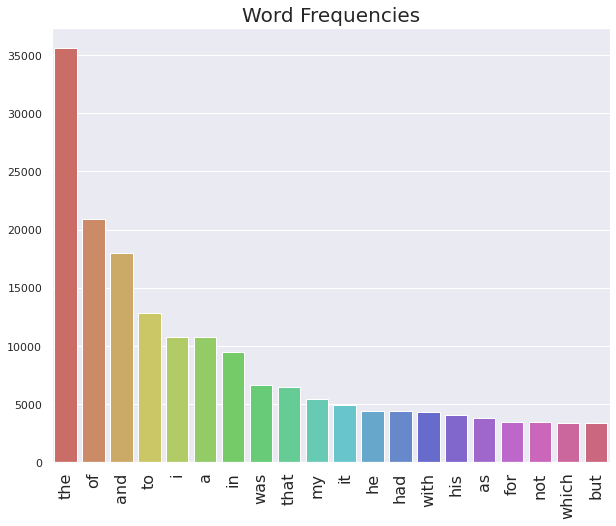

In [44]:
def word_frequency_barplot(df, nr_top_words=50):
    """
    df should have a column named count
    """
    fig, ax = plt.subplots(1,1, figsize=(10,8))
    
    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)
    
    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=16, rotation=90)
    
    return ax

ax = word_frequency_barplot(tokenized_only_df, 20)
ax.set_title("Word Frequencies", fontsize=20);

## 2.2) Remove words that mean little

In [45]:
pd.set_option('display.max_colwidth', 400)
train_data[['id', 'text', 'tokenized_text']].head(2)

,id,text,tokenized_text
0,id26305,"this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i might make its circuit, and return to the point whence i set out, without being aware of the fact; so perfectly uniform seemed the wall.","[this, process, however, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, dungeon, as, i, might, make, its, circuit, and, return, to, the, point, whence, i, set, out, without, being, aware, of, the, fact, so, perfectly, uniform, seemed, the, wall]"
1,id17569,it never once occurred to me that the fumbling might be a mere mistake.,"[it, never, once, occurred, to, me, that, the, fumbling, might, be, a, mere, mistake]"


In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.append(our_special_word)
    
    df['stopwords_removed'] = list(map(lambda doc: 
                                      [word for word in doc
                                      if word not in stopwords],
                                      df['tokenized_text']))
    
remove_stopwords(train_data)

## 2.3) Stemming

In [56]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def stem_words(df):
    # leaves to leaf
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                    list(map(lemm.lemmatize, sentence)),
                                    df.stopwords_removed))
    
    # running to run, afforded to afford
    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                 list(map(p_stemmer.stem, sentence)),
                                 df.lemmatized_text))

stem_words(train_data)

## 2.4) Vectorized words

In [58]:
pd.set_option('display.max_colwidth', 100)
train_data.head(1)

,id,text,author,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text
0,id26305,"this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i m...",EAP,"[this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i ...","[[this, process, however, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, du...","[this, process, however, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, dun...","[process, however, afforded, means, ascertaining, dimensions, dungeon, might, make, circuit, ret...","[process, however, afforded, mean, ascertaining, dimension, dungeon, might, make, circuit, retur...","[process, howev, afford, mean, ascertain, dimens, dungeon, might, make, circuit, return, point, ..."


In [59]:
dictionary = Dictionary(documents=train_data.stemmed_text.values)

print(f"Found {len(dictionary.values())} words.")

Found 15352 words.


In [60]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify() # Reindexes the remaining words after filtering
print(f"After filter extremes: {len(dictionary.values())} words.")

After filter extremes: 8247 words.


In [0]:
# Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(train_data)

In [0]:
def lda_preprocessing(df):
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

## Visualize the cleansed words frequencies

In [63]:
sorted(train_data.loc[0, 'stemmed_text'])

['afford',
 'ascertain',
 'awar',
 'circuit',
 'dimens',
 'dungeon',
 'fact',
 'howev',
 'make',
 'mean',
 'might',
 'perfectli',
 'point',
 'process',
 'return',
 'seem',
 'set',
 'uniform',
 'wall',
 'whenc',
 'without']

In [64]:
train_data[['stemmed_text', 'bow']].head(2)

,stemmed_text,bow
0,"[process, howev, afford, mean, ascertain, dimens, dungeon, might, make, circuit, return, point, ...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1..."
1,"[never, occur, fumbl, might, mere, mistak]","[(10, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]"


In [0]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_:dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [0]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

In [67]:
cleansed_words_df.head()

,count
one,1502
upon,1272
could,1252
would,1148
?,1025


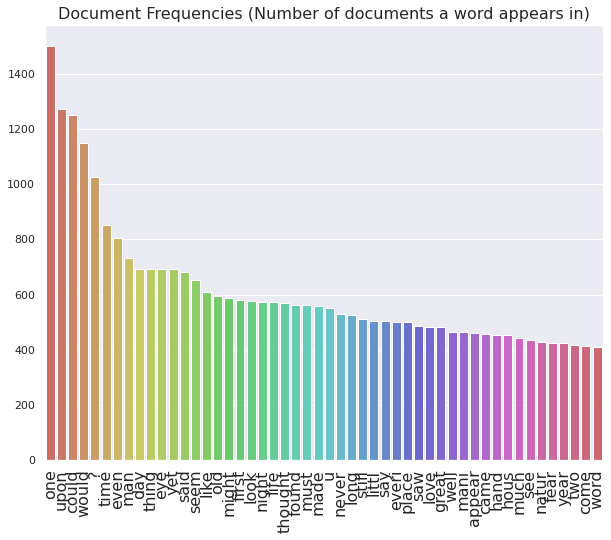

In [68]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

Something I wanted to try out is see how often each of the writers used these words in the plot above and see if we can already find something interesting.

In [0]:
EAP_words = list(np.concatenate(train_data.loc[train_data.author == 'EAP', 'stemmed_text'].values))
HPL_words = list(np.concatenate(train_data.loc[train_data.author == 'HPL', 'stemmed_text'].values))
MWS_words = list(np.concatenate(train_data.loc[train_data.author == 'MWS', 'stemmed_text'].values))

In [0]:
EAP_word_frequencies = {word: EAP_words.count(word) for word in cleansed_words_df.index[:50]}
HPL_word_frequencies = {word: HPL_words.count(word) for word in cleansed_words_df.index[:50]}
MWS_word_frequencies = {word: MWS_words.count(word) for word in cleansed_words_df.index[:50]}

In [71]:
EAP_word_frequencies

{'?': 509,
 'appear': 224,
 'came': 128,
 'come': 89,
 'could': 458,
 'day': 258,
 'even': 295,
 'everi': 206,
 'eye': 270,
 'fear': 71,
 'first': 249,
 'found': 239,
 'great': 229,
 'hand': 186,
 'hous': 115,
 'life': 115,
 'like': 185,
 'littl': 277,
 'long': 224,
 'look': 186,
 'love': 74,
 'made': 263,
 'man': 257,
 'mani': 161,
 'might': 188,
 'much': 230,
 'must': 196,
 'natur': 188,
 'never': 202,
 'night': 151,
 'old': 139,
 'one': 672,
 'place': 156,
 'said': 356,
 'saw': 118,
 'say': 334,
 'see': 146,
 'seem': 201,
 'still': 199,
 'thing': 221,
 'thought': 198,
 'time': 315,
 'two': 213,
 'u': 241,
 'upon': 1025,
 'well': 267,
 'word': 192,
 'would': 416,
 'year': 128,
 'yet': 232}

In [0]:
frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

frequencies_df['MWS_freq'] = list(map(lambda word:
                                     MWS_word_frequencies[word],
                                     frequencies_df.index))
frequencies_df['MWS_HPL_freq'] = list(map(lambda word:
                                          MWS_word_frequencies[word] + HPL_word_frequencies[word],
                                          frequencies_df.index))
frequencies_df['MWS_HPL_EAP_freq'] = list(map(lambda word:
                                              MWS_word_frequencies[word] + HPL_word_frequencies[word] + EAP_word_frequencies[word],
                                              frequencies_df.index))

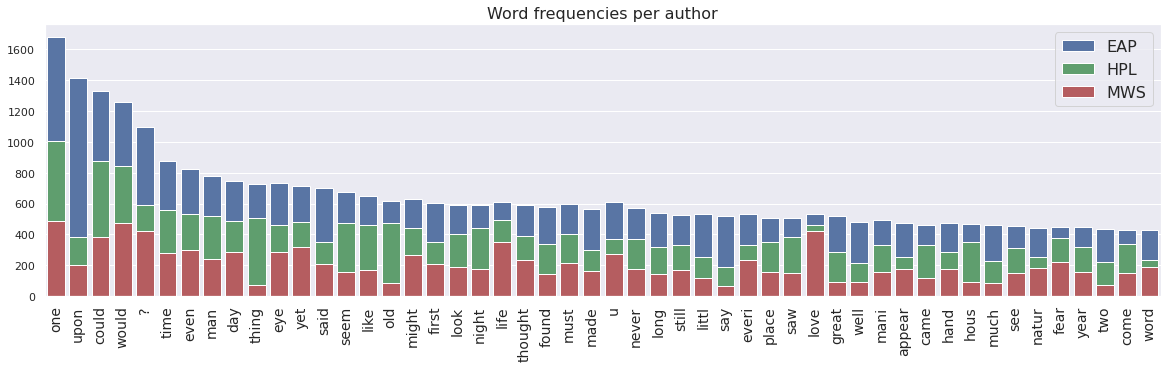

In [73]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))

sns.barplot(nrs, frequencies_df['MWS_HPL_EAP_freq'].values, color='b', ax=ax, label="EAP")
sns.barplot(nrs, frequencies_df['MWS_HPL_freq'].values, color='g', ax=ax, label="HPL")
sns.barplot(nrs, frequencies_df['MWS_freq'].values, color='r', ax=ax, label="MWS")

ax.set_title("Word frequencies per author", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

# 3) Model Training

## LDA

Latent Dirichlet Allocation (LDA) is generative approach in classifying texts. It is a three level hierarchical Bayesian model where it creates probabilities on word level, on document level and on corpus level (corpus means all documents). The objective function looks pretty complex, but it's just a way of describing the probability of a corpus:

$$p(\mathcal{D} | \alpha, \eta) = \prod_{m=1}^{M} \int p(\theta_{m} | \alpha) \prod_{n=1}^{N_{m}} \sum_{i=1}^{k} p(z_{mn}^{i} | \theta_{m}) p(w_{mn} | z_{mn}^{i}, \eta) d\theta_{m}$$

where $w_{mn}$ represents word $n$ from document $m$. The three level hierarchical Bayesian model can now be summarized as follows. First of all, parameters $\alpha$ and $\eta$ are corpus level parameters. Second, variables $\theta_{1},...,\theta_{M}$ are document level parameters. Third, all the $z_{mn}^{i}$ and $w_{mn}$ are word level variables. So we have $M$ documents, we have $k$ topics and we have $N_{m}$ words per document.

This is the objective function that we want to optimize with LDA; we want to maximize the probability of the corpus in the training set.

There's one more thing I'd like to point out, before we start training the model. We have to pick two priors:
- **Dir($\alpha$) for the topic distribution** and
- **a Multinomial($\theta$) for the words (given a topic)**.

**Usually both priors are uniformly distributed**, however, it is only natural to assume that *some topics occur more often than others, therefor we will give $\alpha$ an asymmetric prior*.

We could do the same for $\theta$ for the word distributions, but that wouldn't make sense anymore for the following reason. We don't know what words in what topics appear with greater probabilities. For that reason, we keep the uniform distribution the prior distribution and let the model learn by itself what words in what topics appear with greater probabilities.


# LDA training

In [77]:
train_data.head(1)

,id,text,author,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow
0,id26305,"this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i m...",EAP,"[this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i ...","[[this, process, however, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, du...","[this, process, however, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, dun...","[process, however, afforded, means, ascertaining, dimensions, dungeon, might, make, circuit, ret...","[process, however, afforded, mean, ascertaining, dimension, dungeon, might, make, circuit, retur...","[process, howev, afford, mean, ascertain, dimens, dungeon, might, make, circuit, return, point, ...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1..."


In [0]:
corpus = train_data.bow

In [76]:
%%time
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        #workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 1min 58s, sys: 5.64 s, total: 2min 4s
Wall time: 2min 8s


## LDA topic inspection

In [0]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

train_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      train_data.bow))

Now let's continue with the author individual topic distributions and let's see some words that come with the topics.

In [0]:
train_data.loc[train_data.author == 'EAP', 'lda_features']




In [0]:
EAP_topic_distribution = train_data.loc[train_data.author == 'EAP', 'lda_features'].mean()
HPL_topic_distribution = train_data.loc[train_data.author == 'HPL', 'lda_features'].mean()
MWS_topic_distribution = train_data.loc[train_data.author == 'MWS', 'lda_features'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


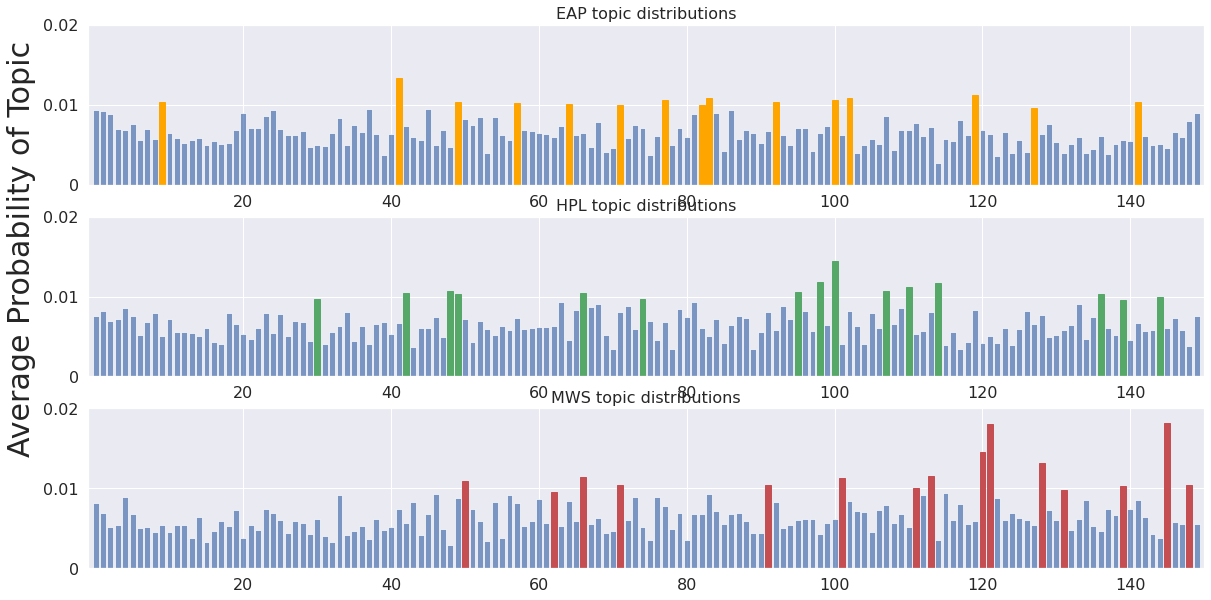

In [140]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,10))

nr_top_bars = 15

ax1.set_title("EAP topic distributions", fontsize=16)
ax2.set_title("HPL topic distributions", fontsize=16)
ax3.set_title("MWS topic distributions", fontsize=16)
ax3.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3],
                                   [EAP_topic_distribution,HPL_topic_distribution,MWS_topic_distribution],
                                   ['orange','g','r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 150)
    ax.set_xticks(range(20,149,20))
    ax.set_xticklabels(range(20,149,20), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=3.)

For the sake of classification, it's good to see that the top topics differ per author :) Let's have a look at what words these top topics contain.

In [0]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [84]:
for author, distribution in zip(['EAP', 'HPL', 'MWS'], [EAP_topic_distribution, HPL_topic_distribution, MWS_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(author))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from EAP.
For topic 41, the top words are: noth, step, longer, question, singular.
For topic 77, the top words are: minut, ask, increas, five, six.
For topic 83, the top words are: attent, subject, expect, promis, realli.
For topic 102, the top words are: right, sat, bed, side, tabl.
For topic 119, the top words are: open, bodi, door, thrown, main.

Looking up top words from top topics from HPL.
For topic 48, the top words are: say, big, run, like, print.
For topic 98, the top words are: street, chamber, hideou, gaze, enough.
For topic 100, the top words are: know, nt, believ, known, well.
For topic 110, the top words are: two, west, struggl, help, silent.
For topic 114, the top words are: thing, like, plain, lake, look.

Looking up top words from top topics from MWS.
For topic 113, the top words are: follow, talk, result, complet, endeavour.
For topic 120, the top words are: speak, affect, self, miser, former.
For topic 121, the top words are: happ

In [0]:
def show_image(base64_encoded_image):
    """ Decodes a base64 encoded image and plots it.
    """
    fig, ax = plt.subplots(figsize=(10,10))

    decoded_image = base64.b64decode(base64_encoded_image)
    img = io.BytesIO(decoded_image)
    img = mpimg.imread(img, format='PNG')

    ax.imshow(img)
    ax.axis('off');

## Word2Vec

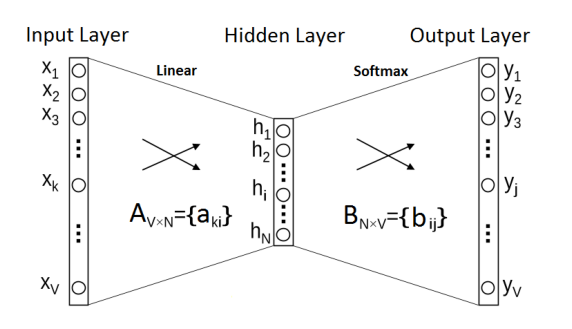

In [87]:
w2v_layers_png = b'iVBORw0KGgoAAAANSUhEUgAAAygAAAHICAYAAAClL85aAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAJSzSURBVHhe7f0PjFRlvuePP/yGSdxc7y6TYII7mtGkey7OhR3MlR1AXSFAoAUiBBCIEHD5a4DQLhBhwQCxDZCG0HyBQCOuTYSAAgEj0BAgYBDwBm+YCezoncZA4hjc4AYTJ3FunLv1q9fT56k+VV3/61T1qVPvlzlW1alD/etznud5f/72isUxQgghhBBCCBEC/n/erRBCCCGEEEL0OBIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNAggSKEEEIIIYQIDRIoQgghhBBCiNDQMwKlfaHp1auX3Ra2e/tEdm5vN896v9mz2297O4UQ0aDdLPSu715FD4pBvIYQQgjR88iDIoSoHYoQ+u0LvUV/r2dN2n/iM7jIeFACMsKIasF3zXfbnt1udPZWAI0XkUcCpezcNtuf1cAlRFRpP7HXu2fM1T92ePeEEJHDCZMXu675blxtNPWa74UoGQkUIYQogYaJC7x7xgz7Tb13TwgRJawn1SdMFpyOmVgsZetoMcO85zuFykJT3mDLajSAymgr8kMCRQghSqGhNbFAubKsztsphIgKt7c/axLaZFiL6Yhf660N3mM/dcvMlfhzpxM2i73mRS3ChSgKCRQhhBBCiLS0m+bGq979Beb0lWUmlxmiobXDtDhXytVG06yaFUIUTCgFCtaKVPdfV6Kq27K7TtO9RmKfb8tW7KbrPbO9V4bKOYkkunqTGNtcbGpiK7f71+FzqXbb0n8G/2+VsyBQHlXZ0v32Ob9/4nXdcanfI0PSshBCCBEAt7c3Gec8WXC61aRznHSnzixb2xX6ufdErklUCJFK+D0o3iK1e07aXvNifH9e1TS9ag/1CaXQxd4X4wvdvF6kOukUWT6R1I3O3zG1CkbduJcTsbR7m7K7qLuShBeYiamjd5bf3r13fr8/QjDb9xCih8hDoHfiM2a4reDwjyBeoziDQTqjT6GGo/IhI4woB7fNqQ/dpJNmfstGw8T4v/DYe6LbeVBpA2i66zfdOZvtWpDRtvMYjReVIdwChZPXUyZJCWldAZ5xgZHjD8pr1DcarodhLR1drxHzuWD3vhh8mbpEXLrvfbzY1a7PkK81pnRyJfRdbZydfGLXjTMvJ5780JzK+PO0my59MjH5+yBOvN+ewf10yvsn/ow5f/9bpunZF60VK/lveMUo5F9UBXZi6TyHk/Am6JwTHgTxGkEZDLyJsiTDUUDICCPKR4f5o/t7DPuNKawERoPpqp9xy/wp2wlWaWS01XhRBVRBDsow09KRkpAWX/x3dKkLk4/3lAV6cgJrnVl25XTCwnG1sTm70KlSGlo7F/MZE/oSKuGqSa6Q6ndRXzUfZlIo7Sfif4FOFqRcie3NfnHSXYzx2dzbZ//9r5qr8RdCnCgJWVQdTEhdGbZ2PEuIbO8C2PtiGuHhJ6jXCMJgEIThqAzICCMC5/af4n8ZjwG/zpl7kkr9bxInWMr8WiKlGEBltLVovAg/oRcoC06n/8GT1GwOhcKJmHaBHj91VhYodCJH/W8Sv+OtVBOPz0V99cNTaS0GGS0F8QuxyXtqWMvKjINOV4nWHL9/fCDbr5laBMjVxnrrBci1dfcSFMJts322m5AQFinjGZO2vzRpWoJ4jSANBhCM4SgIZIQRZaPjj97fN/63iVgJcRltvR1+NF6EipALlGEm45hQ92szwLubnSyvEafu112v0m2BXvP4XNTpLAY+EdLNUpAY2IeZl8dluYCyCSQfC9bmrpwiROi4fcp0hbCvTW/dYlLMJjACeY1gDQZBGI4qhowwQiQho20WNF6EhioI8SozvpMx2qRJrmVLuBvT07DSLXqumsaUWom3T32YECEtK5Mvt9t/co7x+L+rT/O+bsvx/kKUi2TXeOYtYVArBp8FNtWalkQ2g0ugrxGEwSAIw1FYkBFG1Boy2haPxotKIoHi42qgQaJhwQmTHPHpmfDHXSZVIvFVNxn2ssl2veXLgF9rehbRokuoF0+wrxFlg4GMMKJ8RHN9kAYZbTVehAQJFB9RizGNXxJmu5dIZVlwuruFOGfsep0Z16VQulyOvrCTYS+Py6LkO2PVu71vmi29y1mIKJDdapkfQbxG/lSPwUBGGFEmSlysd3SVAKvotRsUMtqmQeNFxZBA8YVPRO5kaG9OlKCz4SxFKoC6ZWsTcZcurtxvKcjqrowfVSuGJyEyE8R1EMRrRM1gICOMKCP+kMU0vUyy46vmFNCCtdLIaJsOjReVogYESvZJvSuhKZuFI0sNc38ZwpDhDw0pTXz54i7tIO2zFGRI2vUnyyqOVdQq/njuYgniNbqImMFARhhRVvy9TApMGvdVc8q+YA0ZMtrmRONFZagJD8reFzN01/QnNKWxcPhrmKctKRf/9101rfPg6h9NJc/LfBY2XWXvsuOvLNG0sDlhKciYtOtzg0a1XKEQOfGFiGStauVbzHQjgNeIqsFARhhRbrrmvvipkaNBXxe3zfaubGmzNmu1pUobQGW0BY0X4adGQrw6k5KSG9+0m4U+cZGuIoJfJdMzIam5J52U8xIndaZLJ8QX90E3P8qGf2HTTaR1xmHm3ePBX15v717ve6fpkprAXzM8W3dpLx702XwHfiGqiKR45aaMhpKuJoxpCPg1omQwkBFGlJ2G1q5KfjQ5zNnlmzCirg7fmUrK9qQBVEbbzGi8CA81IFCGmZaWzhMpuTFbVxwirr70nr4G0+qrMbr3Rfdv41uik7KvK2oGuqo+pH6G4rot52owlxBidcvM/sSHS60c4X3/YS3G+3ly4K+P7pFaRi8VGshl+v1SP4cQkSS5uVdjffI1f3v7s3kYOoJ+jQgZDGSEERWgobWrgWH8RIvPWxkW+Bgue3WJE3IcMjXS61kDqIy2Gi/CT214UMbFF8qxdEKCbp6p3VRTYJEd8w1ODi+5Kq8QRpqopXuNYb8x5U5Bq1t2Jf3nR7iRqHVlmfm1tycXfhclZO3J4LC/X7ZeEl2fI8tfQYjqxW+B9SYmJ9DrvZUMjdMyXyNxAnqNajEYyAgjwkWDaU1aQ6Sea97mW93mznHoKQOojLadaLwIPfHFYyTpaBkW4+vFz7ZYfAEsAqEjFr8eO3/XYS3xR0JUGR0tsfiUYs/h+CTs7cxOfD7JPpacXuA9b2JxkZAZ33snNt8/SLxPthcJ4jXidH2n1C3zeJnfmHo6Fp9+O4/L8Rm6ke67Zdi6/+1875vYuj6n+745/+Ypn6GQr1DMbxr/R4njCv25RE/hmwfTbIX/HdOcu4kX8b1X1hdO8xopc3T36zfd91gQf6V8qMxnzorGi8jTi//Fv2zkIOyh07KIhf5K2qQlUSC4cD0rSfzCze55EkKIqsOXPzCsxXTIsysigtZE5UDjRTmpkSR5EQT+6h7Zy+gJIUQV4i9DWk2lYYUQlUfjRVmRQBF5Uv1Np4QQIhsywggh8kXjRXmRQBF5cXt7U1cCnSwFQojIISOMECJfNF6UGwkUkQe+JkSyFAghIoiMMEKIfNF4UX4iK1A6y+vG4puSwUqnziy7wm+p31MIEUVkhBFC5IvGi0oQ2SpeQgghhBBCiOpDIV5CCCGEEEKI0CCBIoQQQgghhAgNEihCCCGEEEKI0CCBIoQQQgghhAgNEihCCCGEEEKI0CCBIoQQQgghhAgNEihCCCGEEEKI0CCBIoQQQgghhAgNEihCCCGEEEKI0CCBIoQQQgghhAgNEihCCCGEEEKI0CCBIoQQQgghhAgNEihCCCGEEEKI0CCBIoQQQgghhAgNvWJxvPuiTHz77bfmyy+/9B5VhkGDBpk+ffp4j4QQQgghqo+eWEOB1lE9iwRKBdi/f7+ZM2eO96gy/H//3/9nli5d6j0SQgghhKgO/va3v5lPP/3UfPTRR+bf/u3fzO7du71nKsfFixfN8OHDvUei0kigVAAnUFatWmX69+/v7S0PXFC833PPPWetDuPHjzeTJ0+2j4UQQgghwgii5JNPPjGHDx8258+ft+uWKVOmmPv375v58+dXZA0FCKN9+/ZJoPQwEigVwAmUSpzs/vd65plnrPXh5MmT5ve//70ZO3asFStDhgwxvXv39v6FEEIIIUTlySRKxowZYx566CF7TCXXUFDp9xPpUZJ8hHn44YfNK6+8Yg4dOmRu3LhhL7TW1lZTX19vrREXLlywg4MQQgghRCX461//ao2nrEMGDhxoxcn06dPNF198Yd5//33z0ksvJcSJqF0kUGoELnYuei5+BgFCv9ra2sxTTz0lsSKEEEKIsuFEyaxZs+y6g8gORMnNmzfNO++8Y0aOHClRIpKIjEBhcX337l27fffdd97e9LjjyNGoRVLFCoMEFgw8KwweDCIMJkIIIYQQxeAXJXhKECWETnV0dCREicLNRSYiI1A4yfEEPPnkk1adf//9994zyXCxcAzbBx984O2tXfjdGCQYLBg0GDwYRPgNJVaEEEIIkS9/+ctfzMGDB83UqVPN008/bS5dumQWLlwoUSIKJlIhXpShwzuAB+Xtt9/29naBl2XFihX2PgnkixcvtvdFJ6lihUGFwYVBhsGGQYfBRwghhBACnCiZNGmSXS98/vnnZtmyZTZCY9u2baoiKooiUgKlrq7OlqGDlpYWc/v2bXvfsX37druPhThiJswqHg8QlbcQCDQoqrQw4LdhUGFwYZBhsGHQYfBhEJJYEUIIIWoTvygZOnSoXa8sX77cGjd7WpSwfrp165ZdP3GrtUp1Erkk+TfeeMPWycZb8vrrr3t7O0/YpqYme3/JkiXWgxI2+MxU2Xr++efNL37xCysGRowYYcOtHnnkETsQkMzeEzixwuDDb4xoYlDiM7377rs5836EEEIIUb0wzzPfjx492gwePNiuA9atW2cT3Zubm3vcU3Ls2DH72VgvkfPC+olb1lPsDzKsn9B3l8+cjwD685//XNO5z8UQOYFCiNfOnTvtfXIp3IL+zTfftCLlsccesxdU2OBzIkQWLVpkPRVU2Vq7dq3ZsmWLDUtDUJ04ccKMGjXKzJgxo0ctAvRReeutt+ygxG/JRYeoYgCQWBFCCCGigV+UMM8z3yNGiKxgHTBo0CDvyJ6DRT+fj/4peE1oqUA0DesnbnnMfgoCIaxYY5UKazAKC5HPzPoyG/yGjz/+uD12165d3l6RExo1RpGZM2fSgDI2YMCAWHwhHevdu7d9fPToUe+IytHW1mbf++LFi96eZFpaWuzni4urWFyUxH744QfvmWQ6OjpicYFiXys+KMTu3bvnPdNFrvcqJzdu3IitX78+FhdT9nPu2bMn9vXXX3vP1jCnF9i/id0WnPZ2dqejZVjiuCyHCSFEKDi9wBvXNG5FCubtffv22Xmc+bypqcnO7z1FtnVNXCjFnnjiCft8XICkXRfB/fv3Y4sWLbJrrYcffjh2+PBh75nu5LuOcuuxxx57zNuTHn5LjmPryd+x2oicB8VBOFKfPn1s/CHKmvApvBJ0Ug8TmzdvNo2NjSZ+gdlmilgkaLCYDnJszp07Z48n3pPwKr5XWMCSgkfl+vXrNscHq8GECROs1YX8H1ycIjMdf7zq3TNm74l2754QQhRP+8Jeplev5O3Z7cn5mcXA676413sgqh7mZ+Zp5mvmbbwSzOPM52vWrAmFpyQVvBgNDQ3Wq0PeMU2p+/Xr5z2bTN++fe33oTs8ayy8KaWGfFH1FPjtPv30U3s/HUTzAGu4MP6OYSWyAoWTcdOmTfY+Fxon5I4dO+zjsHDq1CkbxkXOzOXLl+1tPiC+CAX77LPP0lYrCwNciAxqiK733nvPDiSEpjmxwoAikqn/zTDvnjELJjZ494QQoghubzfPxsVIOhFxtbG+RJHSbk4kXneBOR2LEY1hWhm2vPe1YmihDC1hJlWUME8zXzNvM38zj4eZpUuX2rUEaz0K+eQDeTKIFITMvHnzSgr38ne8379/v71NhVyVM2fO2PuIIpE/kRUogAfFT5iqdnHSIjIQTsePH8+o+jOBSBkwYIC9MMOedOXECiIMCwfQY4UiAAis1GprtUrdsit2kk9M9EIIUSTtzY3G+WQXnO4cVzq303FJUSK3/2RueXfNgolGw1X1wHxL5AaiBKMh0LS5WkSJgyiStrY2m5dL4Z5CwBh85MgRuw577bXXvL2Fw/pt4sSJ9j45wukiWsgvdr3kZs+ebW9FfkRWoJAQTygUIEywDKC2w4ILeSKBK1/PiR9UO8nznPgksFULFCnA0oFY+fjjj+0F/uqrr9rEtZoXK+0L04ZgJEI0nt1ubsf/2/6s99huz5qMhlDf6yW2TBbNdMemee3kz9JuFrpj7WMhRDjweTiGtZiVSQqiwbTGhcqVZdWxEBWlw7zK/IpRkPmW9QPGQuZh5mNCzKsNl2yOqCoGPCnOg1JKqJfzihDS/sknn9j7fhAuQGhXtYi/sBBZgbJhwwbrWWBB7OL/OFHojJ6Ns2fP2hJ1LLrKyb59+2wYGnXDi+WVV16xXqKjR496e6oLv1hpb2+3XiSsGZQFpCoGFhLh42qjqe9Vbxq7UlXiXDWN9RmERLrYjr0vxs/thfHlSxcZj83w2p18aGb3etGk+1dCiBBx9Y+mw7ubi9vbn+00OPi3JOODZyCp7/LOdI4pncdtZyxJ91x8c7aRxHt4r5swenhbl3HGZwCxW/K4lSAf44r/mBRjiv87RykizYkSjH+IEoyBGAWdKGH+rWZY9xBFQoWuYiHnFwM267FiGTNmjF3LweHDh+2tH7f+pMKYKIxIChQUsSs1TJk5TiCncvGq4E1JBdcci+KxY8cm3HHlgtrhDB64BksJO+Pf4t5kIV/tpX25wOfOnWuLABAfikVn5cqVtvSyxIqfYaalozNUo6PF5axcNR+e8i0h4hOu0xvDWjq6QjtOu8COvebFbjNxVxx58rFxkdKcZta+etUuQhKhI1eWGdmGhAgL9aYrpS1+vWfztFo6hUd9svWjE2sYyfXviwEjR/ccGfJjFi5EUKQaQPgeRRpXGlaaruGy0SSGtNvbzWz3nbt5mqoP5knmSzwlGPsw+mH8i4oocbDGI0qG9VopsO5wJYjTrQvzAW9UpjAvEuddCP60adPsrcifyAkUTg5CubjFhedOCup2cyKRUIV3JZXVq1fbfA6ETbmV7ldffWVvg2gWiQUBolQhyy9Wrl27ZkPg+JvhWaH5ZrZqGdEGcXLFuMiMunEvx/d0cvWPzkZ625z6sGvC3e8P42hoNV0a5URiom9oRWS0JseRN0zMHae+4LRyZYQIJXVm2Vr/FcyCvdNLkC45/vb22QnPrN+o4TeCdBoq4q97Jf5cR0ti7GEccEaKZYwl6Z6Lb93GilQjR2Jwig9PexEdXUaTrqf2mqZunz8f40ry77G3yfPeJPJ04mPr/uo0sjhRgjEPox7GPeZONuZRZ92PEt988429deufUmAdxnqxlMI9RLNAapgXETmg8K7iiJxAIR+D6lZ4F/xVu7AcUDELKEeXapHneCz3ixcv9vaUD+ftCGLgcIUAsCZEEb4fFz+FBBArDCZbt261DZJqW6zEqfu16T48d5hEtWJr+fTCGrwtrbER/JV37JYrfCs+oVe7uVGIKNPQmrTod+ChSA6XajfNCc/JArPWZ9SoW7a/y/PgM2oEBeIkIVySjCKIji6jScPErme6jDEFGlf8Bhq8KAsXdo2HC9YmDD/VgBMlLhwaUYKXJMqixI9b7xC2VirutyolCgUvjPNO+cO8XP6JK0csCiNSAgVXGknnQPJTar1p8j24kFHLqZUbNm7caD0ulSCIC8IR5IUadviOTqxQcYS/V2trq7Uc4TWjWobfvVqT+Kvr5IkNk/DHjQshogEiJcmr4NhrXnS5GFkrctWZXyesILfMn7o7XwLEH5aWQv1vurwyqRRgXGlY2eXd6fTSQFwMVYErGGMcRjmMc0QUEFmA0Y68kloQJX7ceqfYsCw/QRmMXRqBEyWE8dOHD7L13yP6hYpqnLuZShXXKpESKLg3WbBjdSf5KRVCvFxvFLwsLG57gl/96lf2ljjKUiGfBaISW5ovDFBc9K48Irk4lBxk8J4/f37tihW/V2VYi+nwhz4kbZ7VMT65NyVmc3+oRAClSIUQ4SCdULn6ofGlruXBVeNzXoSCgo0rdePMy6lKJ8Rlkv2ihMgBIgiY7zDSYayrBcNkOn75y1/aW7f+KQXWYUTQlLqG8od58Xejzx1gSM302qxTKGKgHNv0REagoFZRorjayCPJpIbJScG7wnE0zyl3Qnw6iJskHhGlXcr7swDnO/B6hfZRiRIITxomIVa++OILM378eOtmxf2NWGGg6Im/c8/gs0IWUL0HhrWsDO1ELYQIAH+YU8GCY5j5Tb13NwwUY1xpb06pghhnb1MZCgAUB3M6CduIEiIDMKIOGTJEoiQFhBqGaFchq1iIuuH3Zj3owuWLhYgdlxND7omrrpoppxlhRJI/3yVd9S8RIYHCgp8cEjanZDPxzjvv2OO44Fnc9gQ0aURpp0vYzxfybfAYqTtpF06s8De+efOm/W0Qggz2NIekzHS0xUqdGZcwEfrCOBJ0lu5Mlyh79cNT3rFU9FEJYSGix23zp0Q8lyc4/F7XW39KGS/8xw8wvw5pnkZ+xpX4uOYUzbAWc9pfAGB26jhZORAlWNIxpuEpYV5nwYwoweiGUVWiJBk8Hiz8CaFyiejFgBDk92c9FgRuLXbgwIFEfmym8C7WIeRFE6L3d3/3d95e4SdySfLVAiX/iCGlDPKxY8e8vfmDt4iTG9VficT+aoRBbOTIkVasdHR02EQ1PE6UYHRiJYgY1oLw9QVIbAEX309KbO2WKJ8iPPwhD4ljU3utCCGqCq/vR7ehxe9BGPayGWcFR4NJ5KDHx4DZPuOFv7pX3qFQfsFThsT6dORjXPF/lwVrl5mGZWu7PC0p37vcpIoSwpPx/BMBgCjByNZTxtNqge7xzPFLliwpah6nWTaeC8LDs+WIFIIzjruKYP7k+VQI/Vq3bp33SKRDAqWH4MLCg4NlBNV98OBB75nc4JYcPXq09cDQYKhU12Qt4MTK7t277SRAnX1cu4iVSZMm2d+/4mKlbHSWAu0qEeqns49KVxdpju3oEjQelBpNUwBICFFF7H3Rb5yIb11lq8xpX+8if/J4Z5WvzuMTfVHIZ8s7kdwnePDieq8VeBPEgowrvkpliX4nDabVN8hdbWwuq5jCYk64MaKE8GMWx8z9EiXFQdQMOcWE9zc0NBQ0f2/evNn2xKNoEr99UPB6/mJLM2fO9O6JooiJbsyZMycW5E/T1tZmX+/ixYveni4uX74c69u3r31+ypQpsRs3bnjPpOfAgQOxfv362eObmpq8vV1key+RHv4G8cEq1r9//9jEiRPtb/zDDz94zwohRBVyeoGdC1K3YS0d3gHdia/X8zu+oyUW1wadxyw47e300xFrGeZ/nWEx9zIdLcMS+5P/qf/fLIglP5Xp/VLfp/PzJr6Hd2zm90z+ztl+m2L48ccfYydOnIjFF6qx+OI1Nm/evNj58+djP/30k3eEyIds6xp+U56LC5bYmTNnvL3p4d+PGjXKHs/fIy4OvWeSKWUdFRdN9t/27t07dv/+fW9vdngf/g3vK7qQQElDJQUK3Lt3LzZ+/Hh7DNuQIUNia9eutf+OwY3bJUuW2AuQ5x9++GG7iE5HKReWiFmByG8/YMAAO5Dt27cv70FGCCFEbeMXJczZEiWlk2tds2XLFisIOIa5e9WqVUnrpxUrVtj9PM/GGi+bEbKUdRSGZv7t2LFjvT25kUBJjwRKGiotUBxY8jm5ESAcn7rhOcHSj6DJRCkXlkjGiRU8KxIrQggh0sFiF6Ph9OnT7XzBPM18LoIhn3VNR0eHFYN9+vRJWje5jf08nytKBYpdR7E2c0Lp6NGj3t7cSKCkRzkoHokY3fgWP0m67SNfodwQu3jkyBHz4MED24CJMnV8FqpQXb9+3cRPfrNt27aaLilcSSgbSD8dYoR37Nhhc3+IdR0xYoRNsKNQgRBCiNqDnAdyF8lhJJeRsrEUrGG+YJ725yKI8kNOCgVx7t+/n3b9xLqK51MbeAeJqwpGYjw5RaI0JFA8qPCUbaukKCChm9rnVJaYPXu2PdGplS16DiqurVmzxg50DHJMThMmTLAdYCVWhBAi+vhFydChQ22DveXLl9sqkRIl4aAn1k8UQKBRuOtnsn79evs5RGlIoHi89957WTcWqEIAlhrECnXqOTdgxowZVqxQHYSqIkIIIaofqmXSm4TKmYgSupdTHpY+W83NzRIlNQzGySeffNI8+uijtmUE0Hxx7ty59r4oDQkUIUoAsUJPm8uXL5tDhw7ZMpGvvvqqdfm//fbbEitCCFFl+EUJhif6WiBGECWE/ZYzTEhUDzTK5tzgFmgeSZi+CAYJFCECgrhTJ1boDkt/mtdee80MHjzYihW63gohhAgf5Bg6UUKuIY8RJeSUSJSIdOApIdeFzvGcJ4iTfLv+Y8h0Oc7ktQLpBG4fz9c6EihClAHECgmT586dM+3t7TaHiQS6p556yrz55ps2dlkIIUTPQe4gYTp4SZwooZkvuYaE8UqUiGwwz5PrQgf5QtMACA1MzXX2bwodlEARouz07dvXWloQK3hX6Da7evVq200YsUL1FyGEEOXHL0oodELiO7mE5BQiSgjbFaLcsCbw5zmnbspjkUARoqI4sYJXhVKIWF0I/6qvr7celk8//dQ7UgghRBCQC7h161YrSihoAu+//75EiRAhRgJFiB6CWFVcw8ePH7cTJaUQmUQJA5NYEUKI4kGUYPyhYAnx/JR9pZAJXmxyBfFkCyHCS6QECg1yqKjARhWObLjjiDkVoqdJFSvDhw83ra2t1rMyf/58c+HCBXt+CyGESI8TJRQmQZQwrlKwxIkScgaEENVB5DwouG+pS43VhOY56di/f789hu3s2bPeXiHCAaWKaS5FCAJlLcePH2874kqsCCFEMhQcIZcPUULVRAqSEEIrUSJEdRMpgYILlwoc3JIIR9O8VBAtq1atsvexUtNpVIiw4hcrlDGcPn267VZLgv2sWbPMRx99lFGICyFEFHGihHBYOngTroUooRAJOX7k+gkhqpvIeVAoC7hkyRJ7f9OmTVao+EG0ENbFwg8xI0S1wDk7cuRI884771jPCqUIT548aSdpiRUhRJRxosRVP0SU4CWRKBEimkQySZ6mSrh1WaxRztWBWEG0wIoVKwquWy1EWMBL6MRKR0eHnaAvXbpkQxsRKwcPHrTlM4UQolqhUIjrH7VhwwY7Z1P9kLwSiRLR0zDHunzmfOZbd2yuHGnRSSQFColxO3futPfp8On6TGB1QbRQUpDSgmEFDw+fmQUnViOdzCIbiBXCFbdt22bDwBYuXGjPH8TKpEmTJFaEEFWDEyXk3FHVkOqGNE6kgAiFRPLt1C1ql0qtoXgfl8+cLqXADwUc3LEUwBG5iaRAAeL2SS4GBjtOVhKNYc+ePTZcJkx8//33tvoI7utHH33UJvyNGDHCLjIfeeSRhFtbVcdELuhAi1jBs7J8+XJz69YtM3To0IRYkeAVQoQFCn74PSUs3oYMGWKrGUqUiHzJtYZiDqRBZ5Bh0Bi7Xcd3ckOzQQi2g3Na5CayAgV27NhhBzYGPzrGwsyZM21oTJhg0YiqXrt2rRUgJEKvX7/eeoG4nTJlig1Pa2pqsschVFTFSeQDg+fGjRttzsq6devMl19+aZuVjR492rz77rsSK0KIisP8RTVCqhLiKUGU4AVGlFAQZNq0aRIlIm9yraEmTpxoDXWNjY32OM69oGB9BnhI8NZkgnxRYE5WD548iUWcLVu2xPiabH369Indv3/fe6ZytLW12fe/ePGit6eL+AVln+vbt6897qeffvKeSYb9R48ejQ0YMMAe/8wzz8Tu3bvnPdtFtvcSwhFfCNhzb9CgQbFRo0bF9u3bl/Z8EkKIIGAOO3/+fGzevHmx+AItNnPmzNiJEydiP/74o3eEEOkJYg3FecZ6MC58Y717947t2bPHe6Y7hayjWFPyehzPZ0mH/5iWlhZvr8hFpD0o4LfCEKsfJrBg4xWh8hgWbkoeZ/qM7J88ebK1MJHgT8ga7ktZwEUxcM5RTILziWp2WJ0aGhqsdwU3eGr1OyGEKBTCaU6dOmU9JYTeEAaDdZtcOTwlhGKHLdxaVA+FrKE4zwh5Jp+JIkpUew2iDx6FGvD+QaYwL97HRb2wjhP5EWmBwuLd9TzhpOUxNdNzwWKN5CpCw4hrLAe8BxcIFwr122kulQ98j+bmZuu2JFyHxlRClIIrGoFYee+992xCPfkqEitCiEJBlBBvTzVBckpOnDhhRQkLSKoOEmItUSJKpdg1FJXgOJ5zkFL9QeSk8DqQKcyLawAI71Lj0PyJtEAh6Q6BwQLMnSBtbW1WfKQDATN16lSbYIV3ggUa9/2lioOCig9cGC0tLXlfWH7IJ6AIwNGjR9UNXwSGEytYmQ4dOmT3zZgxwyYckoDIACyEEH78ogRPCfH2LNoo1OFESSbLthDFUMoaCpGCkReRE0RFLb8ncP/+/fbWwWc8c+aMvY9QF/kTWYGCCKHEMJAoNW7cODN27Fj7GK9DuiRzFmIs+OfNm2dPKNx1AwYMsL1Tdu3a5R0VDLw2i8FS3H1UagKqkgkRNFh6li1bZpuhUU2HcMlXX33VVkWRWBGitsHTSnIy8yZjAnMuJc4lSkQlKHUNtXjxYjunZQrLKgReh0R8YA3p58qVK/Za4Vqg+IPIn0gKFMSHC33CyzBmzBh7nwU9JwmhUak1qwnnOn/+vK3yxeDKv+FkokstJ1+QIoD8EZS7K4NcLFycxD5irVKfC1FO/GLFudO5xliYUFUuW/USIUQ0cKKEEFCufeYyFnrklDC/upKrQpSTINZQeDxGjRplPvvss0ByeZ13hJBo1pMOJ1hYq6mxaGFEUqAgPhAhnIDOywC49SgzByRW+S3A//Zv/2ZPMCxAfvr06WMTsHi9oPjmm2/sLa9bKtSLR5ApT0BUCsQJXZwR72yUTCS3i3hziRUhooVflNBLguubZGM8JRIloicIag3l/n0Q6yeM2k6AHDt2zN6CKy+cLbyLMDCEEl5IOs2LTiInUPjjIj4AMYKXwQ/x9SywOCH8Cea4o4m5TzfYoq6LyRPJhEu8D0JNu9fAmiBEpeH8c2IF7wpGgA0bNtg4dHK3/JYkIUR1wJxHhST6JSFKMNCR90iiO0VaJEpET+LWUBiQS8H9+yCKIWEQd2FeTpTg6UH8ELlDnko6tm7danOduc7IfaZPC7da00VQoCA6EB+EpCBGUuGEdAKGkK4PPvjA3s8EJxiDc6nhWH5c6eMg3IpBih0hSoFzkA655Ktcu3bN5m8x+NKIjYIVEitChBe/KKFADMY+xAiihJLkQXj8hQgCt4YqVVi4f+9er1Rch3iic2gM6brHZwrvIkGfthFEIZALQ+4zxSXwpOCxrHUiJVBwPSNOOBmo7JDppMPii7uN46julS5hHnBtkxTMiYX1KCh++ctf2tsgwsYQUKDSdSJMcO05sUL54meeecYOxoSBIVYYgDNdd0KIyoCV1okS+iDxGFFCTolEiQgrQa2h3L8Pav3EmtK9FuLEVY91ZYhTwVhOdM7FixdtzjNhYpT6xyBOyFcQa8RqJlIChcGUPzRbrsoOhHNxHLfpKo2grBmwOUFYZAUZ4sViDU+OKz1XLEwmeIFI9CrV1SlEuXBihcZsiBUGcRZFeFZo4HbhwgWJFSEqBCEn9DfCS+JECc1aKS1O1IFEiQg7QayhmHNYP+HpD3J9R6EloKUFXhRCv9KFd7HGZO1GL5fU9Rv7odbDvCKZJF8qnBQuGZBYwqDjbRFEU6ZMsa+PJblYiPHnIqMsshDVgBusEStYabEUMZCTs+LECl5QIURw+EXJhAkTbHQAlloMBoiS1FxNIcJMEGsoCj8Q1hh0bxJXStgVYaK9RbpoHkQJ12C6VAQXesZ8WctIoKSAOCFBiQGdcqquRHHQvPHGG/YiI2emmBLBWKBZ2GGNVm1tUY34xQpx7kwUxOESBkbDN1zkEitCFAcLJHLAECX0KgHnxZQoEdVOKWso1nnkfiASKJMdJHgg8co4EFKFgNGZHn54dfAU1TISKD44yREnqGqSfMtZqYTJYe3atTaEjGSoQi4wmkYuWrTInsAocCGqHSYaKunRg4jypcTs4r3EsyKxIkR+IEpookqPEvInua4IY6bCHn2MSMYVIgoUu4ZCnBDayDqPXOVyhMe7okqZwruyQWQM1/GWLVvs9VvLSKD4WLp0qT0xyDnxK+ByQeI98YrEQQ4ePDinq5KEeC4sYhZJxCKHRhOOiBqpYoXeRFwbLLqYiHDNF+N1FCKKOFHCHIIoIZzk448/TogSFVARUaXQNRT9STiO0DDEzezZs71ngsUVL8J7kqlYUzoo0Y8woUWGqwhW08SE5caNGzF+jviJ4e0Jjra2NvvacUHh7UmmqakpFl+U2WMGDRoUW7Vqlf03J0+etLcrVqyIxQWTfZ4tfkHGHjx44P3rZHK9lxDVTHzRZa/Rurq62MSJE2MHDhyI/fDDD96zQtQGzFfxBVbsmWeeiY0aNSq2b9++2P37971nhYgWpa6h3JzB8w899JDdl41S1lEdHR3237KdOXPG25udn376KbZo0SL7b8qxBq1WJFA81q9fnzipMm137tzxji6MfE52Tup58+bF+vTp0+192diPMGFiykYpF5YQ1cT169ftIg3xPnbsWC3SRKRxoqR///4SJaKmCGIN1a9fP7v4v3fvnvcvMlPKOoq5iH/LvJQPiJMpU6bYf4OwEl304n/xH6bm8deszgT14YtpiLh//34bUx8/2W1SezZIkMI9+M0339gwFuIjqflN4lU+8YiFvJcQUQGXPe77o0eP2pAWEu6J/VUDU1HNuPOauYlwXjpV67wWtUYQa6hCEs6LWUeRI0mPrz179tjHzEW52l0AOSebNm2y+TCEZIouJFAqQCVFgwSKqHVcB18WdUxOblGnWHxRDXz66adWlNDjoX///jaOnfO3kFh2IaJEpdc1hbwf5bsRFyTdu9xI8mKomJeLU6dO2YR6KophABfJKEleCBEpKHBBGVUaz9GAjpry9H6g3CqTCSXEhQgTiBKsrzQvpTQw1l7OXwq2kCwrcSJEOGF+uXv3bkKc0Jcun+qqeHoaGxttNbKNGzd6e4UfCRQhRGRh8Ees0PuBSQM3PD0hECssBKmAJESlYXHiRAl9f1pbW82QIUPseSpRIkT1QCUwwrno4UXVSapP5hOOTxga8w/bz3/+c9OrV69uG1W9ahkJFCFETYBYobkX5VfpDcEkQllWyhdTplViRZQTRMmFCxfM/PnzracEUUL4CKKEcBAa7kqUCFFdkBtGrgnXL3NMvhB+TBhZto3c41pGAkUIUXOQj0JCImKFnhEsDOlITI18xArNv4QolVRR0tbWZmPOv/jiCytKyC2hmZsQorYgvwyvfraN8aGWkUARQtQ0TqycO3fOtLe3m379+tmmrYTevPnmm7aSkhD5Qhghya+IkoEDB9rQD6rKSZQIIUT+SKAIIYQH5Vvnzp1rxQreFdz3K1eutAtNiRWRCUQJleNmzZplhS0V5BAlN2/etDHpI0eOlCgRQogCkEARQog0+MXKtWvXrEuepEUWoCQ3k+Qsahe/KEHAnjx50saNu0RZREk+ybJCCCG6I4EihBA5IEeFykpUWKL8K2VgqQJGXoHESu1AKdGDBw/aSnAUV7h06ZJZuHChRIkQQgRMZAQKyYhMGiNGjLAWrUxQqYdj2OiJIIQQheAXK1RgohITFZnwrJB3QFI045GIBk6UTJo0yYoSyoMuXrzY5pRs27bNPPfcc96RQgghgiIyAgWrFR2jsWgdOHDATijpWL16tT2GWHLKwgkhRLEgVkh6JvkZsUKFJio14VmRWKle/KJk6NChdr5Yvny59ZRIlAghRPmJVIgXgmPs2LH2/qpVq2yMsB/CMGioA5s2bbLVeoQQIghIgnZiBev6lClTbAUn8hMQK+QrpI5JIjx899135t133zWjR4+2ooRS0+vWrbOJ7s3NzRIlQghRQSKXg7J79267UPjzn/9sY8T9ECsOdOwl+VUIIcoBY9CYMWNsXgILXCo6kURNGBghqBIr4cAvSp5//nlz9+5dK0b4m7311ls13yhNCCF6isgJFMqCrl271t7HS/Ltt9/a+/v377exw4SCIWLCnsj4/fffm1u3btlwNCx5hBwIIaoPxhqSpxErhAhR6en8+fM2nwGx8sEHH+j6riDMCU6UNDQ02MeIErxeEiVCRAPWUIRmlmsNhRHc5TOzvswGxijGG45NNZyLzEROoMAbb7xhS4JyQpJzwsnhREtjY2OoJ6Bjx47ZE/mRRx6xoSGc0FhdeUw8NDHtQojqxImVHTt22AUxFaA+++wzK1a4vsl7kFgJHhYTFEXBS+JECYYqKrKtWbNGokSICEC+HwVLuM5/8Ytf2HG1XGsoGvwyriCAWlpavL3puXLlijVKcWxdXZ23V+QikgKFRQDWSiBhFSslJxLeFWKKwwgTJsKEuHVOYioDkUezZcsWs2LFClvWlOZfo0aNstXKtIgRovohr4GkazwrJGFj8SP/wYkVrICiOPyiZMKECXbMfO+992wxA0SJFgpCRAeEB0Jk0aJFNlqGgiUYpsu5hsIbDozbVIjNhMt97tOnjw39FXkSizDxkyfGV3Rb/OT0nqkscZFk3//ixYvenmS++OKLWFw82WOmT58eu3fvnvdMMvFFTCx+cdnjBg0alPa4XO8lhAg/8UV0LD65xvr372+v+X379sXu37/vPSsywRgZX5DE4sLPbi0tLbE7d+54zwohqpFc6xqu8969e8ceeughO27+8MMP3jPJ5LOGgnzXUbwex7E1NTV5e7vz2GOP2WPmzZvn7RH5EEkPisOfCE/FrnHjxnmPwgMqnpADkjNxEx46dChjdTEsfnS1JkwNxY6VVSVMhYgehByRD0EYGPkRjA+EKuBlJX+C5G7RCZbLt99+24ZzvPrqq9aDzjh6+fJls2zZMus5F0JEk82bN9s1Edc53lHGTcq/pyPoNRSv56r7OS9JKnhz8OYCxVJE/kRaoGzYsMG71xlCFcbkpKVLl9rFBwn9TKb5QEgIbkxi15mYhRDRxYkVKkuRN+HCQQldIoTJTX61hBMlgwcPtqKEBcnHH3+cECXEhwshos2pU6dsGBc5x1z73OZDkGsowvIhU5gXnxH69u1rXnjhBXtf5EdkBQrx2yQlYU3jRISmpiYrBjJB6U+slE8++aTdpk6danunlAtOaHJkiIkksb8QuMAGDBiQVKlMCBFtsNiRP4GlkHwKPLDkV9SCWGG8fPPNN60oee2116ynub29XaJEiBqE4kes7TBOHD9+vOC+dkGtoV555RW7zgQqMqZC3gvQSNwdJ/IjkgKFxFKSomDJkiW2Yo6r6oXHIh14WziBKEeHyw6rJX0LECxnz571jgqWXbt22VsWHIVCnwW+IxcpIR9CiNrCL1YIaQKSP0myxyqYLWmzWnCihOTXlStX2jAORAlhGoTwYpUUQtQeziBDMaF8PSd+glpDMQZR1AhSw7z4fIxhoPCuIvByUSJFXFXbhKS4oo49ePDA7jtz5kwimSl+Etl9jq+//tomWJE05U+uun79emJ/KWRKuOrTp08sruC9R4Xz008/2dfwfz4lyQtR2zCekTRKkjhjA8mbJHNWC65AAGPj+PHjVSBAiBon3bqmrq4uFhcHdh1ULOnWUFDoOurAgQP2eDb/WLtz5067jyR5UTiR86CQkBSf0Ox9Qroo6waUdqPsHJAg5S8x9y//8i82UQo17U+uoiwdm1PAQcLnxNMzduxYb0/h4C4kPIzPp6RZIQQQ6kTIE6FP5GUQ+kBIFKFReIrLMZ6VCqG0r7/+uvWU8BmxiF67ds1+fnlKhBB+iHTBQ1xq2FRQa6iXXnrJemTA37TRhXe5PBVRGJESKIgMJmJuERb+Kl5AzCEnEW43wgYcnFxxsWZjCVPJVA2iVL755ht7SwxkKbh/X4uJskJEFXLl2Eqt1Y9YYRwkJIrQKB4TKoUQYAxkYib+mt5Lld7OnDljRUl9fb0tYMKYTeNE4skZi8s19gohqpuvvvrK3jJmlEoQayjGKsQSkBoAjN0uh3ny5Mn2NpVbt27ZsFyX90x4Lo0mhUenIyUaOHca27Vr17y9yaxatco+T+gWIVzZoEZ2/MSLDR8+3NtTHOnchW5fqb1ZCOXwv7ZCvISofriG2bieywEhU4ROxSfV2H//7/898X6V3EaPHh07fPhwxp4FQggBqesa9zg1XL8Y6Jvkf20oZh3FWo5/w0bvJRf2lSm8izUq60t6t0yZMiU2c+ZMm5bAv1mxYoV3VG0TGQ8KVkDKzQHdPYcMGWLvp0K1LEIe/N4WP1gUcdFh0UPNEiJGac+gcdbBUjtFu38va6MQIl8ImcKzgrfiv/23/2b3kWwan5jLvs2bN8++3//8n//TTJs2TWOXEKIgXMhnEKHtzktd6jhEGoH7XJQWxkMMmcK7KNjE+hOv8ZEjR8z7779vOjo6bHgrPfEUFRPHEypVD1Y4VCvbjz/+6O1ND9ZDd2xqgtX69esTKjh+osQuX77sPVM88UnZvp5fjaOe2YdHpxToPM/ruI6o6d5LCFFdcA2zcT2Xm0qPGRqjhBCFkDpm3Lx50z4OojN76hoKih2j+Dz8OwqU4B3hfrpIHdagPD9nzhxvTxebNm2y/67U6JooEBkPCuqXEpRsLlkpE6hcd2xqgtXs2bOt8t25c6c9jv4C5WiGSOwk3hkXr1gMqG8+KzGUhdYAF0IIIYSoNljzUGadJHTKBBdL0Gsol8dM7gmeGT5jujwZ1pY//PCD7WWVivPklJL8HxUi2QelFBAtuOoWL15s4urZVnggdCzongKcfLj+SJIqts8KtbsJ8VJ9bSGEEELUCjRpJMSLqn/FEvQain4oFCJxFPq6CKbDhw9bI/vvfvc7b2/tIoGSBUSEO8GuXLlib4OEfBjeg2aShVbrIT4R4YQXBjElhIg+rrpXqblrQghRzVBKnXyNLVu2mGPHjnl786dcayi/KMlUvcsP+dPkPVO9i8bgrlWGy2epZSRQ4qxevdr84he/sN6MVFKT6IME99+mTZusd6ahoSFvkcIJPXr0aGs94ER2vV6EENGDMYiSwI888kiiHCXjFUU8mMyEEKLWwLhLkQ9CohAFBw8e9J7JTSXWUIinQYMGeY8yQ08XCjvhEaJIE2tCiocICRQLJxEWyV27dnl7OmFhcODAAXv/n/7pn+xt0CxfvtxWtSFm8emnn84Z7sVFyHGc1DSizEehCyGql1mzZtlrPbVizWeffWYtbnhUhBCi1kAE0MwVgTFz5kwzderUnI1oy7mGIh/GrRkRHfnA+pN0Av4dvVRoGI54KiW3JipIoMThBOUk2bNnj5kwYYIVKtu3b7eTP8KBDvSumU85eOedd6ybkoUGneUHDhxovTq4/XBdcktJOhqacRHiaeFkXrNmjfcKQogownV+9OhRa1W7d++ebSh7586dRKlexgLGqkqDBRLvDQ0XS+3CLIQQxfLcc8+Zmzdv2nUaYyXiA+8yXmfWTh999FHF1lCsHRkbySGh4FI+IK7IXSHBnlLDrAUZV8mPqXk6i3kJyr5R8o2mOfwsbJSBo2FOqY3E8i1Z19HRYcvUxU/YxGfwbzTxaWxsTCqHl4pKeApR/fivexrQpkJ59CeeeMI+P2DAAG9vceQ7ZlCWnfGQ8uv+z+e2IUOG2Maxucq8a4wSQhRCvmMGbSFoesjazT82uS2fNRQUM0bx3u59eY9iYS3Ka0yfPt3bU7vIg+JBQhIl3x48eGAtlGzcb25urlgjMXJS8KbET1Bz7do1aw2IXyi2lB7NfLCgbtu2TSWFhagRqCqYLoGT+Gssh0CoQjnB2uisj1j3CIfFCrl+/XrbUIxbrJfk8MUnZnscFkAhhKgkjIk0PWTtVok1FCH5VBGbP3++jbhhrOS1161b5x2RHv7do48+ahuCp8JrAGN8rSOBkgKuuUw9UioF70snfELPcBO+9NJLaWtpCyGiDTHJmcCgAeUs5IH4GTx4sO0LxRjERM8kTygCkzCVdLglDhzDCjHdCBhiqAmrEEKISlOpNRR5gBhoSLRnHMbQTeJ+rqR7cppdgr4TJA43buaTYB91JFCEECKk+GvqVxpX6cYlk16+fNlO9JnAuENMN5ZLJmryZORJEUJEFUQQyfD0tEOokAvDvlwwPuJtZmwlX2bz5s22zDAFUXgdvDBz5871jq5dJFCEECKk9GQt/EmTJtleAYRxITzy9ShTUOTcuXNWsDDhqhqNECKK0NSb1ADCyvAkFxI6RvoAxU8wBK1atcqWGaZJI4WSMAaVo/RxtSGBIoQQIgkqyBC+gBeEMK5CQaQw6SJwsAwKIYRIhmbdhMZ+/fXXibzn9vb2RPhurSOBIoQQIglyTigOgpWvWOjxxGtgFRRCCJEeQnnJe65UQaZqQQJFCCEiCEmbb7/9tq0uk6sBrJ/bt2/b3iYk6JcSZkCIF/X98cSoT4oQQohCkEARQoiIgSCg6ezatWttojpxzvny1Vdf2dt8kj1z4SrnEOolhBBC5IsEihBCRIi7d+/absr0JSHxslCcmAmiV4ALWaD0sBBCCJEvEihCCBEhECgkWdKYrBgviKscFkRYlqvxr9hqIYQQhSCBIoQQEcKV+S3WA/KrX/3K3n7++ef2thRcl/ue7OcihBCi+pBAEUKICIEHJN+eJelA4OCBoWt8KT1MSNI/c+aMfb0gwsWEEELUDhIoQgghkiB3hRCvDRs2eHsKh14q5J5Mnz7d2yOEEELkhwSKEEKEjFgsZrfZs2d7e7pD52J3XNDQnLF///5my5Yt5tixY97e/KFqFxXEKFO8ePFib68QQgiRHxIoQgghkiBE7Pjx4za5HQ/IwYMHvWdyQxWw0aNHWw/Mvn37SuqlIoQQojaRQBFCCNENPCgff/yxFRgzZ840U6dOtQ0cs4GQocQxyfFNTU1m8uTJ3jNCCCFE/kigCCGESMtzzz1nbt68acaPH2+OHj1qxcfQoUPNm2++afbv328++ugje7t06VJTX19vhQylhQ8cOGDWrFnjvYoQQghRGBIoQgghMkIFLjwply9fNlOmTLENIPGOzJkzx0ycONHe7ty50wqTxsZG09HRYV555RXvXwshhBCFI4EihBAiJ3hTjhw5Yh48eGCuXbtmPSptbW22HDFNIe/du2e2bdumksJCCCFKRgJFCB+XLl0qqfeDED3N5s2bzYgRI+y2adMmu49bt4/nS4EEejrUk19ClbGXXnrJPPPMM96zIoyQG/T666/bAgZCCFENSKCEjLt379reA6kb/QREeWHynjRpknnyySfNrl27bKM5IaoNqmcxjrAhtp944gl76/bxvKgt8HS1tLSYp556SvOJiDRaQ0UHCZSQwcW1fv36bpsurvLz0EMP2QZ1/NZLliyxk3kh5VWFCAPNzc3mzp07GTeeF7UFOUQIFLxfzCeMbdu3b5e3WEQOraGigwSKEB6UU924caNdxM2bN88OdFQlonLR2bNnvaOEKB9UxMLax60QQYHxheabFDBgsYYwoaDBwIED7bkmb7EQImxIoAiRAkm+77zzjvniiy9skzp6P4wdO9bG73/66afeUUIED6E4LCC5FSJoMMKsW7fOjm0IFDr+U4UNIwwlo4UQIixIoAiRgbq6OnPo0CFz48YNM2rUKJtA//zzz9s8FUqtCiFENYIRhopr9LhBoNBYk5LRjG+Mc0II0dNIoIQMXPEktaZuxA6LnmHQoEHm3Llz5uLFi7ZaEWVVsTi++uqrNgxMCCGqEYww7733ni0TjUDBQ4yneMKECdZzLES1oTVUdJBACRmU70xNamV77LHHvCNETzF8+HA7kSNQGPAIwyHZlPKdtVIZiUpniDJCQ0Ttwnnw+eefW2s7C1lVBqtuMMIcP37cGmEY506ePJkwwty+fds7KrowppGLc+rUKXtOs+ElZz8bTUhFdaA1VHSQQBGiQOj7QAw3AoWYbqrj1NfX2+TmqE9klF+mDPPjjz9uevXqZbef//zndh8bv4Prt/Haa695/0pEARZqK1eutKL80UcfNYMHD7Z/ZxayjzzyiBk6dKgqQ1U5iBNECkYYRIvfCBPlHioPP/ywreA4fvz4xPhFAQE3rv393/99YrzjsQw0QpQfCRQhigB3MU3qsMxs2bLF7iO5mQU6i7SoVsVZvHixdaH74bs6SyPWVqyPWNepGiRK57PPPrPNFRHAb7/9trlw4YL3TGVAdC9dutSe25zrlOukuh3nO+KcWxZ2WJxJvOY45TFUNxhh8BYjUPAW+40wUSzX2rdvX5uLkw87d+6UNV6ICiCBIkQJsFhfvny5FSos1Ji8WaRhdYxiqViSa1mcZgPxdvjwYdO/f39vjygGhAG5AHgmVq1aZc+vtWvX2oINo0eProi3juRpPCUsylz+1b1798z7779vq0EhQrmlz8b9+/dNU1OTvQb4fCqVXN04IwzeYgQKXgbOQTwIUfSU5WNQ4fweN26c90gIUU4kUIQIAFe+E6FCk0e8CVEt34kXJRssYjSJlwZCcP78+TYXAGHAuUQSM4tEOH/+vHnzzTft/XJBSA9CA5HCwuzy5cvWsp4JxPqaNWvMtWvXrEWaXkLypFQ/CBV/DxVwnrIo9VDBUzRgwADvUXcoOc/5LYSoDBIoIYOEUxcD69+iHP8bJVhY7tixw1od8TTw92Rhyd+w2hdrWMa3bt1qGhoavD3d4TtrEi8dQuSOHj1qPRaE2lBpiSRmFokuvGTfvn1lXRxSTptYe6zn/E3zrYLDIo+qdwiWWbNmKSclIiCOMcJwDiJQKIyAcCZXo5qNMMythK6RV5epfDz5OPTGEuFHa6joIIESMlgEspBN3TTJVxeU7yQMhh4qNHnkb8ggyaKv2sp3kldCkiwT+IoVK+w5iuhKBUv/7t27vUeiFPjN8VqkeiwQwCTzAiFe5erH8+6779rcF7wgxeQSIVIIS0PgtLa2entFFMA7Rg8VjDAIFM5VxgNCERnnqgWuHbyUhKzhGULsM74hRvxwzRHC6LyXItxoDRUdJFCEKCNMdu3t7bYyDuUPsYgT018N5TtZoE6dOtXm07gY9E2bNtkcBKz5/omcSZx9msSDAe9DplA6/+/OZFwOyDnhb9nc3OztKRxys3gN8pFE9CAkCs8eRhgECuMFRhg8rGE2wlBkgtwuPD94IfFIMr59/fXX9nxHpDjwGh45ckRJ8UL0ABIoQlQAyncSm49AwbtCdRwmyLCV78SKSLgG1lA2woywhvN5ya954403bL4NEOYBLKYRJ5rEg4PfPJPY+7u/+zvvXnlAOLvQRPe3LgbOC857Fq7qkxJdOFe5/slR4u995swZm3tHeF9YjDCMa+TL8LkoMkFuFwYjxjc8QXgJ3fU2bdq0xFi2Z88e89xzz9n7QojKIoEiRAUhZOfmzZt2wY/XAcsdHoqeLt+J+5vKPHwWZw0lNI1kbCykVPNhwemHiZzvwCTOZC+Coyc9UV999ZW9DeJvStgfqG9E9GEhj6cYgYKX78CBA3Y8oR9STxlhGFMp0U14KuFohHUxvmEsYps8eXK33CoeY3yh2MncuXO9vUKISiOBEjJwmxMPm7qVYskU4YIJ0F++k8f8jZnMK12+k4XD6tWrbeM9JmUWkkzkiChC00aOHOkd2R0EC8nQfBcRHdxiEvFZKk5o9aT4FpVlzJgx1qiBQGE+w4BBngdV5yp1HuC5wTvNuEYuFPlajG+MuXh7convhQsX2jwbUX1oDRUdJFBCBhcXlVJSN11c0YMFvr98p5tECf0qd/lOQnjIg8GySF4JIokeG4RxEVdO2EY+5HucqB5IgoYgwrJcr5ae9AiJnuGVV16xgoB8JuYvij4gVKgEWC4jzKeffmoLkbi8Od6X8Y38EgQH4bX5wPma6lkR1YHWUNFBAkWIHoaBkwHUle90PVRIpg+6fOepU6dsbwtisV2XaBYQTOBvvfVWIFZz0bOw+CMRGJF79uzZghs6/upXv7K3lDouFXqogPKTahMW+RR7cI1sgSR0hEpQRhhe49ixYzZn7vnnn7d5fhhO8OAwrvnz5oQQ1YMEihAhAXHgL9/pEpWZdCmTWCwsWCkbi2dm/PjxNq+EZFYmckQRC4jU/BJRnSBAWfyRCMw5RB4RXjIWg/nC4g5LM+dHKZZuFo7kI/B6Er61DeMLRhiECkYYQr04P/F0FGuEQXi7vLkpU6bYvDk3vhFihgdHXhAhqhcJFCFCBotDV76TCZewBcp3UhqzkPKdhOiQfM+ClX4WWLPphkzjP5JZs3UFF9UHf18WaoB3zOUBsDjk71/IuUOvFXf+FAuimIUo55wQgCcDIwyGEQQK3mKMMHiL8zXCkCO1cuVKK7xd3hznN4Yd+pVky5sTQlQPEighA4slg3bqVs58BBFOqITDhIuYwONBaUxCs3L1UOE5KucwgRNWwTnFRI718tChQ4nKSiJa7Nq1y/6tESUULuD8wYpMCB/jxwcffOAdmRtyo/r372+2bNliw2cKhUUjOU0sSDP1cxG1CyF/GGEQFQgUwgkxwhB+mklIs5/SxYxrnJcIb8Y3xjW6vHO+CqE1VHSQQAkZuKmxeKduKtNZuyBOECmE3LDoxDpOWENqDxUskCSI1tfX28o5hNWQKMoEjtVSeQDRBuGJVTrVgvxP//RP9raQUq+ExrjGm3hADh486D2TG96HhSYeGBrhKf5fZAJvMecZXl3GOcKzMMLQINYZYQhbRLywH/HNv2F8Y1wjbEzhg8KP1lDRQQJFiCqBkCwmcpfcjvhAjDCZ/5f/8l/sJI6IYaFK927CKLCEa4FYG+A1wSqdikuSL/Q8wCKNB49/N3PmTHue5QoTQ8iwkCTcjKpN9JkQIheMWRhhECgYYWig+A//8A/mF7/4hQ1zxfjivMh4XSgDrLw5IaKNBIoQVQSWbRai5KUgWH788Uc7mdO3hCR4qjchYmiiqARRAa2trfa2GLFA8z3OLRaJnGeID6ol0dOCxHsSnLldunSpFcsIGQQRlu41a9Z4ryJEfvzjP/6jDflCFP+///f/bA7Tz372MxvWiqdl3Lhx3pFCiKgjgSJEFUEsLaFdWLdZHCJC/ut//a/mP/7H/2gXknQ+Dqp8p6g8VN1y1bcyQUgLx7DlCm+hzDDhMIRpITaKgffAk3L58mWbhE83brwjvD+LSW7Jc0GYkOuE547cFyHyBY/b/PnzbSiOK0f8P/7H/zAbN240jzzyiPUM8hxd4UupLCeEqB4kUISoAkgiJcQGKzWhXYQ3sEgk3v+f//mfzb/+67/axSGPWTDiTQm6h4ooP/RsYDHGbSYQpxzDli0xmNh9BAVds0kiLhUEzpEjR8yDBw/MtWvXrEeFcEPCCvHa3bt3z+Y6KSdA5AuhW1QnJKeOfCXOHcY3+pfQ0JEu8OSaMNYBjxEqVIiTEUaIaCOBEjJYTDAgp25KcK5NEBn0QaEMJwtCFqQsCjknCKFxeQVM7CwO8aIgUEgwxbpNOE4pPVREdYIXjb8/8fzt7e2BdnLHa8c4RcgY4YaEGqoynMgXhIXLVSJvjrwSzifGN5c35z9fMcYw1jHmIVAI+6KsMKKmmApzItpoDRUdJFBCBoMxCdCpm/IJagdCGCgZi7eERSb5JoT80PQOAcKiMFOCqL+HCv+WiiYsAhoaGgrqgyGqF84dRCrNGoMWJ0IUC8ICrwhlgslVIlSQMYrQQTxyCN5s8xzGGEK+WGwiUAh3xUOI0CH3TgjQGio6SKAIERIIzyL5+NFHHzVLliyxZRFZaCI2WGiOGTPGOzI3dO8mqZTJn+o3iBsmcvoIZOuhIqobck4I9WPhRt6IxInoaRhvyJtDmKxYscIKFc5RqnExRhWaG4W3mJBF/j3nOYYXxDiGGEJhhRDRQAJFiB6GCZYqNcRWu1hrmtxhKcQbQphOsTD5U76TMApeh+pKhEZQdamQvhgi/NB3BMs0f+f3339fFkPRo+C9JW+O8Ya8EsTypk2bErlKeHtLgX9PThQGHIwwhLISCksvKBlhhKh+JFCE6CGwdhN6hWeDvBJiZKmGxAT+1ltvBZpsTHlOJnLXQ4X3QRBt2LDBWjRF9fP2229bkYK4RXz6uyizqVGZKDfkl5A3R+4bG3kleHMZd0h8p/hDof14coEgxwjDxn2KNiCKMPrICCNE9SKBIkQFIb+EBGaqbLm8ErwcTKokiC5evDhjfkkQkL9CaAQWTRYKlPREqGzfvl3lO6scziEgrp+/aepGsQUhygElphlDEAYu943eOTRexDDCuFNujx5eFN4LUYQRBlHEeb9y5UoZYYSoQiRQhKgATJBYuJkwySuh7j+9KSjPSp4IlZAqBQsFKuUgiFzPAWLC+WzqoVK98Dfk75lp43khggQPxerVq21+CecXXjoS2CnmQQ7UyJEjvSMrB8n2GGEoW4wRZsuWLXZsY/yVEUaIKiImyk5bW1uMn/rixYvenvJRyfcSuYmLgNiSJUtiDz30kP27xCfMWHwij925c8c7oud58OCB/UzuM9bV1cVOnDjhPSuiTqXHDI1R1c+NGzdic+bMifXu3dv+Lfv27RuLi+DYvXv3vCPCwY8//hiLCxQ77vI5+/XrF9u5c2fsp59+8o7ITD7HiMqgMao2kQdFiDJAaWCSNSkVTL5HfAK3YVUkvpMgSghCWMDKyGfCo4J3h3wFwjRIOM3VQwWLpPqs1BacH+QupW4Ko4k+NP8cPXp0Im+ORPU9e/bY/JJ169aFrkkn4bLLly+34y65WZyjVEgkFI1eLNmg4iE5XUKInkECRYiAIDTqgw8+sAt74v3JCaCB3eHDh+0ESVgVYiCskKRP1TDCMxAolOykdCcLkkw9VFpbW22lHiWj1g4IlNTwMTYJlGiCEYLO7eTNubwS8j0Y3wilWrhwYVnz5oKAcZfCI4zDixYtsucwFe8QWhQrSYV9jNvz58/39gghKo0EihAlwsKMBFG8JeSVsLBngX/x4kWbYzJt2rSqKvlKt3r6E9A8jYUICxIm8hkzZiSV7+R7UzYUKyMVc4QQ0YHrGs8Y+Rvklbi8ORLRGdsqmTcXFHh4du/ebYUV3wXDC8VKMMSQ2O+gYz0gwjDCCCEqjwSKEEVCQigNyJjASRDFi4B1jlApFvgs7quZIUOG2IUIlcYo34lFkdCI1157zX5XRJnznHAMj4UQ1Q1ChGucxHc8Y3hQaLCI9+HQoUN2LKh2CE3juyC2aPJImCplkQnLJZne7zHmu/ObCCEqiwSKEAWChwRvAsKEvBLCG2iwSBw21rlSG5CFDTrYM5EjUMidIeac7051HD9YHTOFggkhwg2LdBboGCG4xvE2uLy55uZmGwIaNRBb586ds4YYwnHxmJCr4ocSyoz3qm4oRGWRQBEiT2hARigAOSYs1gmFopQlE/iaNWtsInyUIVSN0AgWL4gyJm4/WFoJ9VIpz2jD3x6hmrqpc331waKbZHFCOBnbXN4cvUTwBIc9by4o8HYTjksoWzowvLz55pveIyFEJZBAESILLLaJQSa/hLwSrIyEBBDSRDL53LlzQ58gGiQsQvGoZBIhTOT0RRDRhdA/RHnqFkULe1Qhf2zr1q3WE0qy+K1bt+z4Rk8mFur0Eqk1wcmYdvLkSe9Rd/AYq2KhEJVDAkWINJBbgcWMOGzySsg3oQQvoU6EBLBIr1VInM3mJSEsJF1lHCFEz0L1Kpc3R24FifCU3cUzSt7cc8895x1Ze2zevDlrNUK8TZQeVrU6ISqDBIoQPrAkUlqSCZy8EiYlciuwEFOCNwoJoqXA73PgwAHvUWYIlVAPASHCAXlzlAPHE+zy5qjAd+/ePbNjx47I5c0VCqKD3yUXGKooICCEKD8SKEJ4YD2j1j95JYSr0GCRCXzjxo2ha0DWU9CoDSsrMdvk4KTmIbhwNyZy9RAQIhzgHSCvZMCAAbbBIgaXN954oybyS/KBfDoECr+N2xj/U3v94HVijPOXWxdClIdetJP37osysX//fhseRKWQcpeereR7RRHCukgSHTdunJJ+RU1Q6TFDY1TlITfs//7f/2tGjhzp7RGietAYVZvIgyKED7oN04BM4kSI9LDYpeJT6pYtfl/0LISmSpwIIaoJCRQhhBB5Q7w+1YxSN5WXFkIIERQSKEIIIYQQQojQIIEihBBCCCGECA0SKEIIIYQQQojQECmBQuWFXr162e3gwYPe3mToa/H000/bY+h1QXlBIYQQ+UE56dTyq2wqWSuEECIoIiVQZs+enSgJR3O9dEmbiBiq0AB1zh9++GF7XwghRG4QKOvWreu2SaAIIYQIisiFeO3evduWiKVRHM2p/FB9Zu3atfb+lClTbK8LIYQQQgghRHiInEChuzXeE9i0aVNSbf6tW7fax3hNtm3b5u0VQgghhBAifzCE3717N68eUBjIOZaNVAORm0gmya9Zs8bU1dXZEK/Vq1fbfZwUW7ZssfebmprMY489Zu8LIYQQQghRCEuXLrW5zPX19Tn7QLljBw4cKIGSJ5EUKA899JDNL4G2tjbz+eefW6HCCfTMM8+YxYsX2+fCCmqcz0zzM/JlvvvuO+8ZIYToWRhHnSXQv2nSFUKEgUqtoebMmWNvKbZ09uxZez8djI1nzpyx9ydOnGjXqCI3kRQoMGbMGDN9+nR7f9asWebw4cM2N8XlqIQN3H9vv/22VdePPvqoGTx4sBkxYoStOPbII4/YW57Px5UohBDl4rPPPrOWwNSNcAchhOgJcq2hhg4darZv357T01EIrDNdcZCjR4/a23R8+umnCZHk1qUiN5EVKECeCSfPl19+aR8vWbLEelDCxrFjx+wETwI/kzwnMGU7W1pa7C0J/VgoeZ7jNmzYIGulEBEEax+TKpurNiiEECIzmdZQhPVzO378eHPr1i3T2Nhow7HwrAQBnhDWZ3DixImM4ufUqVP2tm/fvlbUiPyItEDhZGBzUB4zbKD4OcHx6uzZs8fcv3/fHDp0yJbtXLZsmb09cuSI3U+4Grk1XHDPP/+8vClCRAysgEyebNwXQgiRmWxrqOXLl9vbjz/+2O4n/5hxdfTo0bblRBA4j0i2MC/ECxDeFcYInrASaYFC1a7bt297j4xd2GcKQ3j99dfNjBkzvEeVgWaSKH4qj924ccMsXLgw48nLfvq8XL9+3SxatMiGWTQ0NKjRpBBCCCFqjkLWUHg7KKB07do1a7ieN29eIJ6UkSNHJoouHThwwN76IYLHrUMV3lUYkRUohEQhSICEeTwPKGeESDoIp2DRXynwfiA0+vXrZy5evJh3VTEuMvJocFXymefPn+89I4QQQggRfYpdQw0YMMCcO3fOrqXITw4iJ8WFeZ08ebKb0ZjwM0AUvfDCC/a+yI/IChRKunHicTKiql1VLxKZslVbqBQ0keREJkaSC6xQyK8ZNWqUTf6/cOGCt1cIIcrLkCFDzJ07d7ptKt0uhKgUpayhWBfSL4+ImtbWVm9v8RDdAqw5P/roI3vf4ap3uTA0kT+RFCicIChZ2LFjhz0pSEwaO3as3YfqDrKSQzEgLPDqvPLKK96ewsGTAk58CSFEucHySD5f6qbJVwhRKUpdQ5GfQtNuXqdUBg0aZD8L+Kt5UbmLCl5QylqvVomcQEFRU60LiPcbPny4vQ9OrBD+RSWsXFApizwWlHqQVbOoz4170gmmYuGCeO6556xCVy6KENGE6jMrV660OWdU93rttddC4QUWQoieIIg1FIYW1oeE9gfRJ8X1RPGvx5w3Be8ya7VUyHtmTNd4np7ICRSEB247Tr7m5mZvbycs6FesWGHv4xZk4s8GzR05npMrSOvgN998Y2+DKHlMuAXeoEzJ/0KI6uXdd9+1dfwZr5j4SOqkUg0Tc6Z8OiGEiDJBraHcvw9i/TRt2jR7y3rMCQ4XyeNyVFJBHDGmqyJreiIlUBAc9A4BKjuki4l+4403bLwiHhEskZmgOgSLAl4naNecKx/qGvyUgou91AkuRLT453/+ZxuOSoUaCn4Qyol3mLAEYKwLogqNEEJUE0GtoVwbiiBKumMAx2AMrieKyz+ZPHmyvU2F3L1YLJbIYRHJREqgUA8bUYIqJr4wHZzQCA9iplHNqQlNQHUsFgbUrH7rrbe8vcHhFhhBXBRBih0hRHhAlDAGUT6TWv6LFy+2YarU9Hd88MEH3j0hhKgNglpDudAu93ql4soII0xozohIyRTeJXITKYFCcx4UKb1CCPHKBB4RV3nmpZde8vZ2gidi0qRJ1mr5/vvve3uD5Ze//KW99fdoKRbXbRrBJYSIDhgd3nvvvW7hpcRNMz4BsdhCCFFLBLWGcv8+XbRNMRDmxXiN8CH6BlxuSjrILXz11VcTifQimcjloJQCYV8kLZFEjwclKFWdCh4eXvv8+fPenuIgEYvXQJ3LgyJEtCBuOdMY5ARKEMmdQghRTQS1huLfM5YW0+ohHbyOK8xEg0bIFN4FVPxqa2szX331lbdH+JFA8UHIFxZJ1DQ1sss1+aOwSXIlQcp5QIqB6mK4EGfOnOntEUJEhWwJoD1tkMDTzFhJDgxjmISSEKJSBLGGIryfcWz8+PHenmDwe0zIS6EEsSgOCRQfKHI6khLaxYSbLYm+VJYtW2ZvyZspBtQ5uTRcAHPnzvX2CiGiQlBhB0GBZ5mQhKeeeso8+uijZvDgwbZEJlXGHnnkETN06FCzfft2azQRQohyUsoaimiZTZs2WaFDbl+Q+NMGXE6KKA4JFB9UdMBqiYuOajm4344dO+Y9GyyEZaHceQ8qhhUCqn/ChAn2IqPkaGqMuhCi+vnZz37m3etZCCVdunSpqa+vt0YRElPx2pLETyUxbhnLqKLY2Nhoj1N1MSFEOSllDUX0Cd4XQvmDzt/1e3TUnLE0JFAysHHjRnvicgKXK3zhnXfesaIIl2C+QgjPCVZLkrtYLIwcOdJ7RghR6yAe8HQE1ReJ8QZPCSWOMd5QPvPevXvWy0xlMayY3FJZ7P79+6apqcl+htGjR5v9+/d7ryKEEMFTzBoKLy8J7OSesM4LmtbWVntLyWGXKyiKQwIlA4R74Z0oZ6gXCVXHjx+374UrkMaQmcIj8Jag+gmjQJzgnnQuTiGEACbfJ5980jz//PPenuLBU4vQQKQgPC5fvtyt6qEfKieuWbPGXLt2zS4a5s2bJ0+KEKJsFLKGwnAyf/586+UlfNb9uyDBe3L48GF7nygcURoSKB4kMrkmO44xY8YkkuVLSWbPBm5KJnRySRAdjz/+uL2IUOFYBLjlMTHffBYuKKyYNJwUQgg/jGNYEzN1Li4Eyq3jiSGMC+GRbyjpgAEDzLlz56xgmTVrlnJShBBlI9caateuXXYcYv++ffvsOo9WFEF7NwhxbWhosMZkXtt1lhfFI4HisW3bNttHJRVcgCTOl7MSAyfzzZs3bcgW1Xm4iAgtY5HBLY/Zz8XX0dFhxo0b5/1LIYToAg8HvVOam5u9PcXx7rvv2hhtvCDFeGoRKRhUEDgu5EEIIcpBtjUUnowDBw5YAcN+xExQZYWBEFg2ioXgdcaQQwiscoNLRwIlJHAy0/0eAcKFdvLkSVsfm9svvvjC7sdrkq0BpRBCBAE5J3hrSxE6jGe8hgt5EEKIcpFpDUVXd/bduHGjLBVPKbfOhucEcUSES7YS8SJ/JFBCCNZHvCSzZ8+2t0q0EkLkQxA5KOS4EdI6ceLEkvqtYEyhIiKeGPVJEUJUCv8ailB9vCflwjVb5Pbrr79WhEuASKAIIURECKKKl+tqnJqTVwzOkhhUVTEhhAgTdIpHCHEbdNJ9rSOBIoQQIgFx1BBEnLbzwCCchBBCiHyRQBFCiJBA7yUaH7JlayBG+BXHUDIzaIIUFe41ZFkUQoguyFlR6Gt2JFCEECIkIEpofMiWTaBQrcs1SgyaX/3qV/Y2iNLq5LMAfQeEEKLWoRwxTWxnzJhh/vKXv9h9//iP/2hvRTISKEIIIRJQUh1BQTWaUjl//rwt8hFkWU8hhKhW/uVf/sX2qiKpnoa2tI9Q1a/0SKAIIYRIYubMmTaxnX4oxfLRRx/ZfJbx48d7e4QQorYhof7Bgwfm3r175v79+2q6nQUJFCGEEEkwaZKLsnbt2kTSfCEQX41lkN4Eixcv9vYKIYRgbJVXOTcSKEIIIZJgAm1pabHiZNKkSYlY6XzZvHmz7X9CN+dsuTRCCCFEOiRQhBBCdINQBKqEITRGjx6dtyeFZpF4Xsg92bhxo7dXCCGEyB8JFCGEEGlpbm5OiJSnn346a04KJYXnz59vjyfJ/vjx4yovLIQQoigkUIQQIiJQfritrc1s2bLF21Ma5JBs27bNvuZf//pXM2/ePPP444+bpUuXWrFy7Ngxs2vXLjNr1iy7f9++fbYD/fXr160HRQghhCgGCRQhhIgIlAgmNGvy5MnenmDgNe/cuWNWrVplH+/cudOKlSlTppglS5aYAwcOmLq6OitQrl27pgRQIYQQJSGBIoQQIickzpNT8vXXX5sbN27YPil4Vs6cOWM6Ojrsvrlz53pHCyGEEMUjgSKEEKIg8NQQToZnZcyYMdZ7IoQQQgSFBIqoEW6b7c/2Mr16+baF7d5zQgghhBAiLEigiNrg9inz4VXvvmNvk9l+27svhBBCCCFCgQSKqAnamxtNqj4x8T0fnpJCEaIQ7t69azZs2NBto8ywEEIIEQQSKKIGaDcn9np3U7j64SkjiZI/v//9783Bgwdtp3D/4jSs0DTQfUY+M5+d7yCKB4Gyfv36bpsESpm4vd086w9NzbotjI92QghR/UigiOjTfsJ06ZMFpqVlmHc/ztUPjZwouTl79qypr6+3zfpmzpxpy836F6dhpaWlJfEZ+cx8dr4D34XvJETYuX3qwzTe30zsNS9KqAghIoAEiog87X73yYKJZtm4l02XRFGYVy4uXbpkxo8fb27f7vqdnnjiiSShElboau6Eib/SFN+F78R3EyJ6IFSeVY5dwLQv9Hmrnt0u77sQZUQCRUSc5PCuBRMbjKkbZ172O1Eam2VtzMLbb79t/va3v3mPjG3MR9+L999/3/bFWLdunfdM+Fi2bJn9jHxWPvOKFSu8Z4z9Tnw3IaqHBeZ0LGZi6baOFp/hBa6axtlaRKeDa59wzxkzZpiBAweaJ598MrE9//zz3lHhZuXKlUmfG6/whAkTzK5du8xf//pX7yghqhcJFBFpbm9vSgrvQp/EFYoZ51co8SNOSKFk5NNPP/XuGfPwww+b5uZm07t3b29PdYFY6du3r/co+buJ/HjooYesBy11q9ZzIjLULTNXYqfjo5wPhbB2g1ypoUOHWq/q4cOHza1bt2xeldv+/Oc/e0eGm++++y7pc+MVPnnypDUgIbr8Hm8hqhEJFBFhbptT/trCCyYaq0/i1CWFecUlihRKRvzWOBr0sUDNm2wJvj0QIsEiesCAAd6j5O8m8mPIkCHmzp073bbHHnvMO0L0HA2m9bRfoiiENZXXX3/dfP75596jznDVffv2mS+++MKex5cvX/aeCTcYivi8eIaPHj1qnnnmGe+ZzhBWvENCVDMSKCK6pPQ+seFdjrplZq1/Ht97QmFeeZCvlfz29mc7RUh9uvLOHlcbTT3HqGGmEMFR/5uUUC/hILQLr4kDY8vFixfN3LlzTf/+/a1YqRahjSeYz0tu3eTJk+338OfZIcK+/PJL75EQ1YcEiogsSdVvhrWYlT59Ag0TkxSKwrwCobNjf31j/nWHzN4XJVKEEGWH8C2/1/S5556zi/woQPjtxIkTvUedfPvtt949IaoPCRQRUZLDu4a9PM502ZY8GiYmxWvvbaruhNJuIVR5biRYBkeH+WOSNsmQ1JsUhhJHXf2FEBUmamGJiBQhooIEiogm7c2my4g/zLw8rps8idNgkpwoSigNjmEtpsOKkdZE3k8SDa0pVYcUKy9EECT3Tck09gkhRLiRQBGRJKn3ybCXTaY5OjnMq7oXyW1tbUVtW7Zs8V4hCBpMK8LkyrLuHqtUUss9/7HDuyfCDJ34R4wY0W1TOEkIuL3dzPaHVy5Ya5ZVoT7hXNq/f39RmxqwChERYqLsxBeBMX7qixcvenvKRyXfK7ycjsVlh/0d2Ia1dHj709ERaxnWdawZ1hLfIxwPHjzo+m3i2/Dhw71nguH0At9vv+C0t7e88B3834nvWMsUOmZwnP/3c9udO3e8I7KjMaowOlqG+X7nBfHRLQOnF/iOy3FsyMl0juWzZRujOEf9x86ZM8d7Jj+SxquUuSL57+S2YbGs00/ArF+/Pun9o3KNVXrM0BgVDuRBEdGj/YSv90muEIeUnigK80rio48+8u514i/RGzi3/lSRHCB/OU44duyYd0+IsEOH+PS5ZL1e9HuNCbHMEF5ZBWTqtZPP1q9fP+9VKkT7Qvv7py8MctU01sf/Nuo6L0TBSKCIyJEU3pVHiENyT5T4hNKsilLAwp2mXw4m/jfeeMN7lC+dVb26Laa8zb+mqhR0l/cvYhobG80HH3zgPRIiAlDCu4or42XqtZPPdujQIe9Vys+phfFxLJ9BjL9HD4iUf//3f/fuCVF9SKCIaHF7u2nyzxeUsE2zME7aUnt11HBPlNWrV5upU6eaxx9/3EyZMsX85S9/sfvHjh1rrl27ln/VG8+q2KtXva9YQTjgO/Bd+E7Ad5w+fbr9znz3lStX2v1CVDV27HtW1fF8/Ou//qt3r5OCms6mEhcdjX5b2GlflcJ0lQrjx88u8x8jdXwmX0yIakUCRUSK5Ao2xVK7PVFoYkZXYvoFAM3ASKI/fvy4DZ/Ih/Z8rYo9CN+F78R3c94UvjPfnU1kht9u/fr13bY+ffp4R4jykaFst9uSKuMBIUYL1YQ2Dk0aOU/9YIQpGa9iYWtqPF23SoVolOay/i3GjBmTJLp27typ4hWiapFAEREiufdJKexNo1Du3r1rJ7lcsNDN99hUsObzb51AyATHfPfdd96jTrp5hvLc/H1QmMBXrFhhG5gB78Hj+vr6/KrjtC/sHra14HT6xVR8SzUypmPGjBl59Wp5/vnn7XHbt2/39mTmwoUL9jvx3dwEPnz4cLNq1apuixiRDAJl3bp13TYJlBBQt8xc6XZd7TUv1nAjVLqpHzx40Dz99NPms88+8/Yas2nTJjNy5EjvUZEwtmWrWBj/e+xv8UuU8hq/8KAcOHAgIVKYJwYPHmzHxFu3biU1qRQi7EigiOhw+5Tx65NhLR1pF8Xptw6TPI90D/Ni8ZsrV4EFPQvf0aNHm969e3t784e8D96HjYk1EzxfjlCk2bNnm+bmZnP58mVz/fr1JO/C+PHjzeeff24fZyIp/8cMMy0d8d+2m2mxMBAQTLRBwUTNd3EikO/Id7148aLZuHGj/Q2EqGYaWk8nNaGt1bBVDDBPPfWUmTlzpr3uuda5z/VeeD5dCnhO8hjb6patTW4IXGb3/OTJk83NmzfNokWLTF1dnR3nyLMbOHCg+Q//4T8EOpYKUU4kUERkKK1BWUo1L7PXNKWJF25ra/PupYeqV1ip5syZ4+0pDrwvS5cu9R7lB5+tmC1THxSqXe3Zs8d71PmZcnknkvRJhXswIKpIkiUJPhu7du1KsiTyHVMrewlR3aQ0oTW3zJ+qKBelXH1Qvv/+e/va/+f//B9vTyWoN7/xTy1ZqhUiHi5dupTk6QG3P9+cEgxlfE/nHRaiKomJshNfBFaspnYl3ytcJPc+Sa1RnxcdLbH4PJLxNeKL2Fjv3r1jX3/9tbenO88995z9t9mOyYb7+/Fe3J44ccJ7JhmeK7SGfzH88MMPnb+Ft+Xqg+L/G2TvP9NJtr4CDte3JChS+6DwHWuZSo8ZtTtGFUfefVBSSP533ftx3Lhxw/bN2LRpk7cnPRyTaRzKxcmTJ+2//+KLL7w9mWlpabHH/vTTT/bc6PrshW2pYxRj8YEDB2IDBgxIOq6xsdE7In/yGa/SkfTvsvwN+f4c88QTT3h7OnH7c42/sHPnTjtPuffjtfbs2RPr6Mj304YPjVG1iTwoIhok9T6JT8cvj8vdyTyVlM7mJqUnCl4RvAiZ+mbgSv/000/NqFGjkqqpvP7664lqWKm0tramdbmvXbvWhiOQI9GTccMPP/ywdy8//JbCqx+eylJWs7P8cLG59M7DxOZ+W0LeXn311W69W3JR6HesdTgfOWdTt2JyrkTP8Yc//MHmW5F3hechExwTFyjeo8LgnODf5/K83r5924Yh4SUgNDbIPiiMxa+88oqJCzKbZ+aIC6KCx4py88ILL9jfi9/Cj9ufyzPPdci/ddcivwffe+HChTbcS4hqQgJFRILk3IcFZm1RsUV1Ztlaf1zEVfOhT6FMmzbNTpxtbenDvNwknzqJMEk0NDR0EylM2ufPn+9WGhL+03/6T6apqclO3Fu3bvX2hp/kppeNpr5X9wpCt7c/a0otP/zaa6/ZCjWIQScwqL7F30alNcsL4ScuT8q/5SrsICpJasGQAebXGYZExjRECuFPQTNu3DhbCZBrM5uATR07y9EHBeHD9/Rz5swZ7155qU+K8coMAoqCE6lhqm5/rvw4wtv8vzN9rFS8QlQrEigiArSn5D5MLL6DcsPEpIRGvxeAiZbkahbAJFymQvUUFsskKfphsqGcpV+kIE7wtjCZZkqmnzt3rs2NoNpMtSz+UhNCyeVJ7XydvuNy/rz77rtm3759VsC99NJL3l4hhOP29tnJBoAsY+K8efNsrsLmzZu9PbnJ5tVljHOLZMY2ktLJiTh16pTdlw7Km6cbO4PmH/7hH7x7nVTKO93xR98fY9hvTL13NxVEIl6Q1PHe7c+VU5L6/KBBg7x7QlQfEiii+rn9J+OXCwsmllI1KiW5NE2YF6RW80K0UHULIeKvQ+/wixQWArnEiWPbtm12wqeBYnXQYFq79WLIACU68z3WA+s91Wn4O6xZs8bbK4TopN0s7GYEGGZaVmYeExEFeCIploHHNh8IpUwX6spYxRjnT1R3Vn8MOOlgLOR9GR+jGW552/ypuz0rLRiu8EZSMt2P20/J9UL42c9+5t0TovqQQBHVj1f7P+ZtJVa1NQ2tXa8Vi11JqkRFIyxinFPDvFyIQjYXPCIFLwyxz++//35OcQL0I8ECyeTORF4VuL9HpiYnri9K6h9qwK+z5g1hHZw0aZIN/3jnnXe8vdHA5c/gHRIiM909ksnbi0m5eLDgdPIYlg4MIZBv5UCuP0Is/SLFiROEBqFdDqz4bCdPnkx4kP04Y09ky3unlr8vJj9SiBpEAkWIAnAhC7jgSegEwhmIsSbXxJ+EmQpWMP49ie+zZs3KGpPth94cWBZJts/335SLdAuMjNBJOSH0fJtfmPjFZQ5liThBpPAb5yPuMtHTv2E6XP5M1YhQUQV0dp3Px2AzYMAAG+pFTkY+DVkZjz7++OOESPGLk3RlvvF4Ek6V6nnmWiS8K9fYGUquNprZaUrRp5Jc/h47jOSJEPkggSJEgThLH92J4ZNPPrGCJTU53o8/52T58uXWM4K7Pp/FMkn0JHfSJDFbtZ1y4U+yJPemHMm0+UAMNt4TcnKKTYTns/v/bTRDSspLpgTmdMUeROnUjXu5oDBI20DQiv7WgnLxMIRwrZNYnc+45BcpQ4cOzShOgCpaGBVSw7wQQ+SnZBs7w8zVxnrTK1uX/tvbzWx/uF38b5Ml2k4I4UMCJWSwCNuwYUO3racWhaI7WBtJXqf0prMAQqYQhXQJ8UzkhYgURA1WxnJV28kG8ekOrKDz58/vkfPx4sWLid+QcKh8fjc/fGY+u98LNHbsWO+eyJdMJWBL8WqJLKSEsObcriwrKoQIcYL4Jx+EMStfuA7ZsglUQlu51vA6+xPAnWCp6vCuvS+aXr2eNanOFFutsL4xyXuyYG1xfxuRP1pDRQcJlJDBxUW989RNF1e4wOKH5Q/vCUKF8AQWaengb5cuIR6RwuI/nwpdLApJYuU9GWxTa/2XEyyr/vcjHOnRRx+1VtMRI0bYrRL079/f/sZU78IL8vbbb3vPZAYByOfjs/KZ+ewOvhPfTQjRCZUDMcBwjeWqGOUP67p+/Xq3nJRUnJfEeZ7594ydGGoyjZ3lJp+xNxMLTp/2VSy8ahrrk/OBulUrXHC65PzIXBQUghtRtIaKDhIoQhSB64mCRyNXiAL16zNZl2mgle/kTLUdhBALgUpORDT4unbtmpk4cWLie+BJoaIWFlGXi1MpEHaEGbGISlfu2Y/7jNy6kqJ8B74L30nNy4TogmuDIh4s5t58801vb3f84oTrMTUnJR2uJ4rzmnAc12Qlw7vw8vjDOhkbqL5YHA2mNdZhWvKIvxvW0pEzx65U+JukhtD1lPATIggkUIQoAtcThbwQJrxy1+937Nixw95W2lLGRHf8+HHz4MEDu7An3Mq/VRIWUe+99569JWQrW6gXniv/5+Sz8x34LmGevFkg7tq1yxZTwAPE9yTBuNCwNiEKZeTIkVZ40GuI8S0dU6dO7ZZz4hcpFy5c8PZ2gUFn+vTp1qhAGBneE/Zh7KkUjBkUA3BwPY0ePdpea3xXrO+FeVXqzLIrhNb5vSk+vIqFV4pqHJwdDGN8Xn5PvFJ4if1eL7zzEiiimpFAEaJI3njjDes63rNnT5JVrhR++9vf2tfMNLEQfsHCgWPwAlQavifeCzw5/q2cYGHl+/oh3IvcH+LamaShsbHRHvfCCy/Yx5D6WXkc1N+qXGDRHThwoE1WxiKKlZe/OYs7xIrCOES5aW5utuKBssPpOpFjIPCLE4cTKb/73e+8Pcn4C4xQMQyRU+nr8a233krKPUOQcK0NHjw4bQ8SP/4S9MkOEbwpXc8ltjJ6TShNzudlrKCypN+bTFlnStkLUc1IoIQMJgUWp6kblh8RLkiUJ3yLCjVBwcTCa/I3zwSTPMfUShd1931T4fuz34VpsWDicbkFUzkhL4bQGUQIDSkRXJSldjlAFFvIJ/em3GCpxeKMeCIfCGuuiA6MP5x3hEami93PlgOH4MgkOhgzMbKQT1fp8C4Hn629vd32ZeH9+Uz+ubZaqtHhxfd/buYOjBgYbsgJyvY3ijJaQ0UHCZSQoRKeQtQueOOYSG/evGl2795tBRfW7Bs3biQWHK5qXKXBU4XV9qmnnrIFB7A449F5+umnzSOPPGJDTKj+5HJ9RHWDh7gc8w6iAAHOaxNO1lOQE4MniMW8f669fPmyd0S4YVzwf27GCEJaCZmr5cW41lDRQQJFCCFCAtZqunSnTqaIE6yjgFCopMeCxSShPvX19dbyzWckpATvDgnV3JKPRYgJYXYcV+nCCaJwyJtj4caCLh14Glj0cgyL4aBYvHixfU1eWySDF5jfplpEkhDlRAJFCCFCAuFqmULUyLtxVCoPhXwYPCUkPrveP/fu3bPx7Xh3XFgdeQf379+3ldUQMCQe90RTUZE/CBBCXwiJyYQLI+I2KFwITpCvGRXI9+G3STVQyCspahEJFCGECAmIgExkW0iWA/JMEBqIFIQHVt1seU98vjVr1thKaSw+qZYkT4oQpYExwl1HmXJ7hIgiEihCCBESKi1CsjFp0iRb4YgwLoRHvnHtJEGfO3fOfhfKJMv6K0Rx0PDx7//+722xAq4/QiiFqBUkUEIGFXFIPE3dcnX1FUKIoHj33XftoggvSLpysrlApNDEFIHT2trq7RVCFAL5XWybNm2yOTs9WVSgWtAaKjpIoIQM4rdx56ZuskIKISoFOSeEk5SSHL18+XL7Gj1VdUyIaof8LjYqqiH6RW60hooOEihCCFHFYBlkAsbjkQ2OIZ8kF3T5xgpJI9B0TfryhRAvEv75XOqTIoQQohAkUIQQooo5e/asDWGgDwkiJBMcs3nzZu9RZr766it7m6n8bCG4pH9CvYQQQoh8kUARQoiIQL+Sv/3tb96j4nCx2kF0onZVhwi7EEIIIfJFAiVkUAPdJcb5t1JCLYQQ0cc1SyTBvRRcf4ogwrJcvxaVRxVCVAKtoaKDBErI4OJyiXH+TReXECIblCClmSPVs0rxWPzqV7+yt59//rm9LQWX85LaeE4IIcqB1lDRQQJFCCEiwM9+9jPbswRxsnr1am9v4VAtiI72dI0vpfINoWZnzpyxrxdEuJgQQojaQQJFCCEiwpgxY8zYsWPNvn37bLhXsSxatMiGeG3YsMHbUziEmiGWpk+f7u0RQggh8kMCRQghehjCs4iTprRvJn7729/mFU+9Y8cOe0vCfLHQnJFwsS1btphjx455e/OHql1r1661n3Px4sXeXiGEECI/JFBCBiEVd+/e7baVWplHCBFeEATESb/00kvenu4MGjQor3hqwrNWrFhhSw4XIy6gd+/e5vjx4za5HQ/IwYMHvWdyQxWw0aNHWw8MnhzFfgshKoXWUNFBAiVk0NTsySef7Lapj4AQIl/oPE3eB0Kl2DwSPCgff/yxFRgzZ840U6dOtQ0cs4GQefrpp21yfFNTk5k8ebL3jBBClB+toaKDBIoQQkQMRAUCAcvh1q1bvb2F89xzz5mbN2/aEsZHjx614oOGkG+++abZv3+/+eijj+wt4WT19fVWyFBa+MCBA2bNmjXeqwghhBCFIYEihBARZO7cubaTO0KlFOshnhg8KZcvXzZTpkyxyfe85pw5c2zODLc7d+60woRcmo6ODvPKK694/1oIIYQoHAkUIYSIKNu2bbMhXitXriw5FwRvypEjR8yDBw/MtWvXrEelra3NliO+fv26uXfvnn0/lRQWQghRKhIoQggRURAVhF0dPny4pJ4mfkigHzJkiM0vmT17tk3sx1MjhBBCBIUESshg4r9z5063TZ2YhRDFsHHjRluNKyiBIoQQYUVrqOgggRIyHnroIfPEE09027BaCiFEKs8++6wNtaLqVjqYmMkh4RjyUoQQIqpoDRUdJFCEEKKKoe8JoVbZcj+GDx9ujyHkSwghhAg7EihCCCHMH/7wB9vcsdwbPVKEEEKIbPSKxfHuizJBnwBKcV68eNFaMstJJd9LCFGd0FX5k08+sZW4evXqZXbv3u09UzmmTZtmlixZIq+OECIrlV7XaB0VDiRQKoAEihCipyFJ/uzZs7YsMN2WqbxFXxNCxD7//HPvqMrAZ/n3f/93O07RV2XUqFG2p8oLL7ygWHEhRBISKLWJBEoFkEARQvQENE+k2/vJkyfN73//e+utmD59eqiEgBNOeHMQToxbdK4fM2aMTXgVQtQ2Eii1iXJQhBAiQnz33Xfm3XffNRMmTDBDhw61wmTx4sXmiy++MO+8844ZOXJkqLwUiBB6qbz//vv2MyKgEFRPPfWUmTVrlvnggw+s0BJCCFE7SKAIIUSV8+c//9ls377djBgxwjQ0NJi7d++at956y9y8edM0NzdXTZ4HwgkBhZCid8HChQutV+Xpp582kyZNMgcPHrQCTAghRLSRQBFCiCrk9u3b5u2337ZekhkzZlgvAwv769evW3EyaNAg78jqBWG1bds209HRYdatW2crgD3//PNm9OjR1kuEMBNCCBE9JFCEEKJKIFzrzTfftB6F1157zXaIP3LkiLl8+bJZs2aNTXiPKgguhBdhYDt27DDffvutDWNDsOA9wmskhBAiGkigCCFEiPn000/N66+/bgYOHGjFCV2Rz507Z7dly5bZTvG1Bl3zEWQ3btywuStAvgrCDa+Seq0IIUR1I4EihBAhgh4lFy5cMPPnz7eJ4q2trbYk8LVr18zHH39s5s6da/r27esdLRBsCDW8SPw+dNRfunSp/e0QdHidhBBCVBcSKEII0cNQapdywHgBWFgfPnzYltp1HoJXXnnFhnOJ7OBNQsDhXUKwEPK2YcMGU19fb71QeKOEEEKEHwkUIYToAUhqpyoV1akITTp//rytve/KAVN6V31Aigcv0+zZs83x48et0BsyZIj1RiFW8E7hpcJbJYQQInxIoAghRIVwPUqoQkX1LbqoL1++PJH4HbYeJVEB79O0adOsN4rSy3in8FK5Xit4r/BiCSGECAcSKEIIUUZcjxKqTdGjhMf0JmGhvHHjxqrpURIVXGNIvFQIQ7xWeK/wYk2dOtV6tdQYUgghehYJFCGECBjXo2Tw4MG2RwnW+ffee8/2KKGfRxR6lEQB1xgS7xVihWR7kurxbiEm8XapMaQQQlQeCRQhhAgA16OEsCF6lJADQf4DydpvvPFGpHuURAW8WX7vFr1VCMdjwwumxpBCCFEZJFCEEKJIXI8SEq+pFoUIQZBQRWrhwoU12aMkKrjGkCTY796924Z9EQJGqN7mzZutl0wIIUR5kEARQog88fcoefLJJ21VKKpDsYjFW0LVKPUoiR4ITxpD0ovm0KFDNo/l1VdftSF8CFP1WhFCiGCRQBFCiCz4e5TgKaH608SJE23OAlWhqA6lHiW1A14x1xiyvb3dPl65cmWi0796rQghROlIoAghRAr+HiUsPC9dumSrPXV0dNjqT+PGjVOPEmG9Za4xJN6V/v37m61btyYaQ3LeqNeKEEIUjgSKEELE+fbbbxM9Sgjd+fLLL21yO6Jk27Zt6lEisoIXjY7/hPqRZD98+HB7PrnGkGfPnlWvFSGEyBMJFCFEzUKVJn+PEkQKYoTwLRKkyS8RolBcrxVCADmXpk+fbo4ePZrUGFK9VoQQIjMSKEKImgLPCD1KaMzHYhHoUUKiO4nQAwYMsPuECALECt43QgPxxlHdjdAvzj9CCAkl/P77772jhRBCgASKECLyfP7554keJUuXLjX9+vUzH3/8sU10JuFZPUpEJSBEkF4reOkQK4QQIphpDElooRpDCiFEJxIoQojIQWKyv0cJHhMSmF2PEhKb1aNE9DSEEBJKSBgYooUQQ4QKIYdqDCmEqGUkUIQQkYAEZBKRSUhGlNCjBGu161FCArN6lIiwQmghIYacr4QcIrJnzJhhCzYgsNUYUghRS0igCCGqFhKNjx07ZnNJCN8iEZmEZNejZPLkyepRIqoOQg6XL19uPX6I6z59+pjXXnst0WtFjSGFEFFHAkUIUVUQo+96lJBoTCgXiceuRwkJyepRIqICoYiLFy+2oYkXL140TzzxhO1ej1ghhFGNIYUQUUQCRQgReojFdz1KiM8nsZhwGNejhFAu9SgRUcc1hsSrQmPIZ555xuzatct6DwltvHDhghpDCiEigQSKECKUEHPvepRMmDDBJhDv2LEj0aOExZkQtYprDHno0CGbtzJ+/Hhz4MAB61l59dVXba8VNYYUQlQrEihCiNBw69atRI8SFllALonrUUIlLiFEMq4xJMn1dLGfOXOmOXnyZKLXDyGRagwphKgmJFCEED0KMfSuRwkx9fQoId7e9Sgh5l4IkR+EOrrGkHgbyc+iDxDVwMjbUq8VIUQ1IIEihKgoxMgTK+96lGzdutV6Rq5fv57oUaJywEIEg2sMiVhZt26duXv3rhkxYoTN56IUt3qtCCHCiASKEKLsEAt/6tSpRI+StrY2M3z4cBuO4nqUqBywEOVl0KBBNn+L62737t3Wk0J+F3leGArUa0UIERYkUIQQZYGY9w8++CDRo+TEiRO2RwmVt8grIWZe5YCF6BnoteIaQ5JoT2gYeV/krZAHRj6YEEL0FBIoQojAwCK7f//+RI+Szz77zMbA37lzJ9GjROWAhQgX9Foh34u8r/b2dpsHRggmhgXyw8hhEUKISiKBIoQoCWLY6cVATDux7YSJEOvu71EihKgOECfkgZEPRq8V8sPwqBCa6RpDqteKEKLcSKAIIQoGEbJ582Ybu4635Pvvv7cx7cS2E+NOrLsQorrp06ePzQ8jT4xQMIwNJNYjVtQYUghRTiRQhBB58fvf/95s2LDBlislVp38EWLXqb5FLDsx7UKIaEIRi8mTJ9v8MSqCTZkyxRw+fNiKFfLM1BhSCBEkEihCiIwQzrF69WrbnXrlypU2Vp0YddejhMdCiNoC48SYMWNsXhmhnHPmzDGXLl2y4wQeVTWGFEKUigSKECKB61GydOlSmyBL6dEBAwbYWHT1KBFCpOIaQ5JvhlhZvny5rQA2dOhQm5emxpBCiGKQQBGixiEsg/AMYsqxgNKjZNSoUTbmXD1KhBCFQJ7Kxo0bbT5ac3OzLaLR0NBgC2hs375djSGFEHkhgSJEDUL4BWEYM2bMsOWAT548aXuUsKhQjxIhRBBQLIOKfuSpEQ7GuMOYg3eFymBqDCmEyIQEihA1AmEWhFvQOZoFAr0NFi9ebBNe1aNECFFOXGNI8teOHDlivbKvvfaaLbpBrxWKcAghhEMCRYgIQzgFYRXEgrPdvXvXlgHGU6IeJUKInsA1hiSvjaIbTzzxRFIxDopzCCFqGwkUISIGYROET9CjZOrUqTasgh4l5JSoR4kQIkxQdIPiGwgVinEwPlGcgyIdFOtQrxUhahMJFCEiAOERhEkQLkGyO+ET9ChhwlePEiFENcC45W8MSbEOinYgVhjXTp06pV4rQtQIkRAoNIl68sknrXuYjtbp+Pbbb+0gx3EMdEJUO4RBvP766/a8R5wQJoEV8uLFi+pRIoSoaijSQbEO1xiSIh4nTpyw8zhz/gcffKBeK0JEmEgIFCzExNpTe53QlnTQAfvLL7+0QuWNN97w9gpRPbgeJQhsJuldu3aZZ555xnpJPv74Y/UoEUJEEtdrhWIed+7cMQsXLjSfffaZrUDoGkOq14oQ0SISAqV///5m1apV9n5LS0u30oUIl3379tn7a9euVbiLqBpcjxIshnhKDhw4YMaPH2/DHwjhUo8SIUStQXEP1xiSMsYYH8m5c40h1WtFiOonMjkoeFEIccHKTDUQP4TBsB8hI++JCDuuRwkJ7lgIz5w5Y+bMmWMrb7333nvqUSKEEB4k1VP8gzCwHTt22CgJSqkjWKhgSOVCIUT1ERmBwoJtz5499v7Ro0fNpUuX7P2zZ8+a8+fP2/tUMlKfBxFGXI8SOi7To4Skd/JImHQ5b9WjRAghsoMREmMlHmaMOYD3GUOPGkOKIGCu/vnPf2569eqVVz7zI488Yo8lFFEURmQECowZM8Ym0gFeE8JjGhsb7WMs0MOHD7f3ww4WIJroIbJYqCq2Npq4HiUjRoywwoTHGzdutJ6S5uZm9SgRQogiIZQbIw+NIcnR69evn20MSf6eGkNGm3KuocjzHDt2rL1P0YZsJbApZOPee8qUKfZW5E+kBAoQl9qnTx97UrLoIzaVE4oFX5ih+hgWHvIMHn30UVsuloUrlh8UuLMAceGJ6sX1KOHvO2PGDCuiSfy8fv26jaVWjxIhhAgWKhpSRITGkAgWxAuFc+rr660xU40hq59caygiEzAIBlGm2hnCER+ffPKJvZ8OymKDq0gnCiNyAgUrSVNTk73vwry2bNkS6upGx44ds+WPSeDHis7Jv379epvwzy3Kmzhanuc4BlY1rqoeEMtY7Bg4seAhoKnzz0RJTpSKNgghRGVgLTB79uxEr5UhQ4aY1tZWK1YI2VFjyOoj0xqKtR+3FJahWBIRNfyd3dqwWCZPnpwoTnP48GF7mw7SDYD3VzGbIohFkDt37sR69+4d4+tx+/XXX3vP9AxtbW32s1y8eNHb00VcTNnn4oNmbM+ePbGffvrJeyYZ9vM6AwYMsMfHB9XYvXv3vGe7yPZeonLExUcsPhjG+vfvH5s4cWJs3759sfv373vPCiGECBM//vhj7MSJE7F58+bF6urqYjNnzrSP2S96liDWUPwdOTYuFOy6kNfMRD7rKM4P977p3rOjo8M+z8Z5JAonch4UoIqXs4Bwu3LlSns/bFCpCcVPYh+WHGq7Z0qEZj9WH0KBFi1aZGvAE8KmRlXhgPPM9SjBQoNFjh4l/L2w1KlHiRBChBcXhkPILcVJyFulgiIhQlRUZL7WfBsuCllD8felgAJ9w5iL40K0JE9KXKDYW8K8mPtToT0A4DkhP1oUTuQEClW7nMtt06ZN9pbH7PfDQEN8IhU+ckHHWo7lNijIJUFoEJJG5+98u35zkVHVCVcloUPqit9z+HuUkHjJeYYrlyR3uh+rR4kQQlQfLHKpnMhci1gh2Z75ljwGShhTcVHFa3qWYtdQAwYMsLlIrKWYu4vNSeH8cEZH+pOlQgI9TJw40b6XKJxICRROtCVLltj7qFvi+10yEyey/0Rk4cggxIlFIn02du7caZX27373O29P6WzevNmKJGIkucAKhWIAo0aNsovidOpdlAfXo4SSgeSUcF5gaWMSw/KmHiVCCBEtqKhIoR2MT/RcISeUppBsJF6rMWTlKWUNhUihuTd/N6IdioH1o1tfIkb860vEK1EuoOpdxRMpgeLqnCM+XNUuyrayYGRAIbncDwtLYMGZCf4dFT4oUUwjyKBAWJAcjZW9WLDuAAJKlA8GGyxmTEZUBkHQLl++3HYxRiiqR4kQQtQGrjEkIUXMwSySCQGjMSSLZvVaqQylrqGYw1kr8jrFMm3aNHvLOeCP0qF6F2HfFMRReFfxREagsGhESQMxiU5RIypQysDzfm+Jq8SQzj3ncOLFiZkgoD437klXS7tYuDix7BAnywUiggPLCpYxJh2ECX8vRC+eEiYn9SgRQojahjnY5TUcOnTIGkNfffVVa8jCYEpYmAieINZQ/K0wPOPpKDZcj3WAM1y7il1w8uRJe4v3RBEVxRMZgbJ06VLrYmPAQBn7IdSLkwhF68/Z4MRxJXwz1UFva2uzIgYxExTffPONvSWJulQokcj3lou5dFyPEpIi6VHC+UI3YixlTELqUSKEECId5EC4xpDt7e3WSEqBHtcYUr1WgiOoNZT796Wsn1yyPGFerBlYj2E0BhcC5sDTRjnkXO/HWoTjWIfUMpEQKHg5zp8/b+8T7pQaboMQcQnzDBKE6ziojAX79++3t35Q6ZwoiBhESlDQUAiCeE3nKcKaIArH9ShhEqFHCUlvdB1mkkHoIniFEEKIfGEecY0hqeRIlamtW7cmGkOSu8hiVhRHUGsoQrDAvV4x+MO8aNpITjD3OQdeeOEF+5wDjw0G8XTrTT8UZOI4jq9lql6gcGKtWLHC3sfdlynej5PIheVwvHPpudyS1CQncOFdTsQEhbuoggjLct/DVZMQ2WFSQKQySTBZkJfE5IEgYTKhTGG+1UCEEEKIbDDfkydBuXmS7FlzYCR1jSHJXUhde4jsBLWGCkLokHDvoisI7fJX70o1lrMOxWCeK++FyB2Oc+KnVql6gYICvnfvHg0nrVs1GyxCOe7BgwdJC3ryS1jo+5OcWMhyEiFeglaxv/zlL+1truph+YCXh4tAi+rMMPin9ihBrBK6xaTB5CGBJ4QQopyw6KTSI2XoyWckBIjcBTz4lLylbL3ySXMT1BrK/ftS108ulMsvUFLDu4B1BoZ0utpnyk9ykTsIHOfhqVUik4NSCs5Dgmp14KojbCrI5HgHcY+ceC6Rqlj4fLiKEVC1fiKnwiCf2qOEUD0mBSYHVyBBCCGEqDSIFSpAUp6eipB475nPyYGkjD0RHBIr6QliDYURmlwRPCDFtHrw4yqJISwwdiN4+Numw60pM4V5laMwU7UigRLHeUk4WZ3Lz4mVUsoAZwKPB4tlVHRqA8lCIEyJi4weL6LTXcvFzeDOIM9gTxwwgz+TAOF/TApCCCFEWGBNgFefsvXMVxT2wbpPNTCqSKoxZDJBrKH4TVkzpPN0FAqCxB9pw2fLxLhx46wnBc9Zah6Si9zJJnBqCQkUD9QqoUDHjh2zt7jpGDDKlSTNAMRFRmPJYqwklMDlRKZZY5AVxqoNvEiuRwldfhnU+W1djxIGDX5nIYQQohqgOifl7PH4U96eeY45jrL3agzZSSlrKH4/2lHghVm8eLG3tzRcNS/ItibjM3Msn4FIHT+EovO35nmtWyRQEriQH1QtipwTvpwuNoQPlcVwCTY0NBR0gdEMqrGx0Xp+CFeqNfjNXI8Sfjsu6B07diR6lDC4CyGEENUOCdiUuSdnkrL3WNkpP+t6rTAf1iLFrqGc2MMjtW/fvsDC451oxPvhCjJlIl1aAbiefEEXZqpWJFA8ECe45QgLwjNRiQoKlLGdN2+erSpFSFIuVyWfjQuLxpOIE1drvRbAlet6lNAICxBnrkcJlbiEEEKIqOL6vFHwhwIvLK4pjz9w4EBbLr/WGkMWuoYiBJzjiLRoamoKLPoE0YjYAT5PLhCdbP7qsQgsHmNg1XqmEwkUH6hWThaXUF2JJGpyI+hwT81rqjsw0KxevdomUJHkzS3Nntg/YsQI2+8Fzw7lCqN+EtPh1fUoId8GMYYoY3CmIRYiTQghhKg1sNQTnkR5/IsXL9r5kLL5rBWYL2ulMWS2NRQh+9zSyJsKnoROIQTwVGDYDAoqg+JBISyLYgf5wDqOz8JnBFfBTcnxPmIiibh6jcUv9Fj8gvf2lE5bW1uMnzrba3Z0dMTiyjvWp08fe2zqxn6ev3Hjhvcv0pPPe4WVn376yX7uxsbGWF1dXWzixImx+EASe/DggXeEEEIIITLxww8/2Hlz+vTpsf79+8cWLVoUO3/+vJ1fq5Ug1lD9+vWza4t79+55/yIzhayjOOahhx6yx/P++XL//v1YXNDExo8fbx9zy+uwX3TSi//Ff1hRRlDwqOL4iZyzpwquQupgf/PNN1ZN48Kl5jdl9fKhkPcKA3isSBQj9wfvELGbeK+oYKEywEIIIURxML8S9sT8yrqC8CH6a1RbRctKrqEg1/uRzI4XBq8J6xbAo0XIeSE91ag4SvXYO3fumCeffNLERYo5cuSI96xQiFfIwEXIIEJsJCFnNHUq5MKqBpxb0/UoYfCk1J/rUcJ3ljgRQgghigcR4hpDEhZOiBO9Q8jDYP6NYq+VSqyhECYkuPvFCaF2hTZ8RgQhIgnJ45bHogsJFFERqJiBVcL1KCE+llhNLAfEkOIxqSaLjogy7d6tEEJEAxburjEkxkDmXzwNVANjXlavlfz53e9+Z9avX283kuOLzQl2PVHIeybHFs+W6EICRZQNrAwkj7n67ZQDXLduXaJHSa5SfEIIIYQIHtcYErHCvEySOfM087VL+hbpQYzwm7HRDJowsmJANFKVlTCyFStW2MeiCwkUESiIkK1bt9qBbsKECdYis3v37kSPEkrrCRFu6r1bIYSIPszLrjEk8zXzNvO3awxZq71WKgGlksl14VYkI4EiSoba6/4eJVgBDh06lOhRUq5u/EKUB52vQojahPnaNYZkHgfmdeZ35nl6kglRCSRQRFGQQ0KPEmqO06eF+EmSxFyPEpLGhBBCCFGdMI8znzOvu8bQJHRT3Ib5nxwWIcqFBIrIC0r3UVqPhkcMToRxEYd57do1K0yIwyy0goUQQgghwg/ihHme+Z55n/kfjwoNEF1jSNYJQgSFBIrICGXv6G46f/58K0ooqzdq1Cjr+j1+/Lh55ZVXVA5YCCGEqCFICmf+Zx3AeoCEexLrESusFzBmSqyIUpFAEUlQE53a6NRIJ3yLmumpPUpUDlgIIYQQGCnpOcL6gHUCjSApm4tYYR2BkRNjpxCFIoEibMUOaqBTC52a6MSVUiOdcsCuR4nK3wkhhBAiExgv6e3BuoH1A40HL126ZBPsWV9EsTGkKB8SKDUKNc537dpla56PGDHC1kCnpjcWEPUoEUIIIUSxuMaQrtcKZXSpADZ06FC77lBjSJELCZQaglrmJLVR23zq1Knm+++/tzXP6YKqHiVCCCGEKAcYPTdu3GjXG83NzdZI2tDQYA2k9FpRY0iRigRKxKFHCeUACd0ieY14UWqbU4VDPUqEEEIIUUkwhhKxcf36dRsORtjXjBkzrHcFI6oaQwroFYvj3RdlYv/+/TYWs6Wlxfz2t7/19paHs2fPmk2bNplp06aZ//2//7etYz5lyhSb3K4ywEIIIYQII3hRjh07Zk6cOGFFy9ixY20C/h/+8IeKraHAraPo8D58+HBvr6g0EigVwAmUSoJ3ZNWqVSoDLIQQQoiqgvwUKoAdPXrU/Of//J/N//pf/8t7pnJIoPQsEigVAHfllStXvEeVYcyYMbaxkhBCCCFEtdITayjQOqpnkUARQgghhBBChAYlyQshhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIjRIoAghhBBCCCFCgwSKEEIIIYQQIiQY8/8HDDHdwURQ0J8AAAAASUVORK5CYII='
show_image(w2v_layers_png)

Where $V$ is vocabulary size and $N$ is hidden layer size. This is the network in it's simplest form, since here there's only one input vector (basically you'd have given word $w_{i}$ predict word $w_{i+1}$). So the matrix we're eventually interested in, is matrix $A$ with where we have a linear activation function. The following image shows how the where we get the vector representations for the individual words come from.

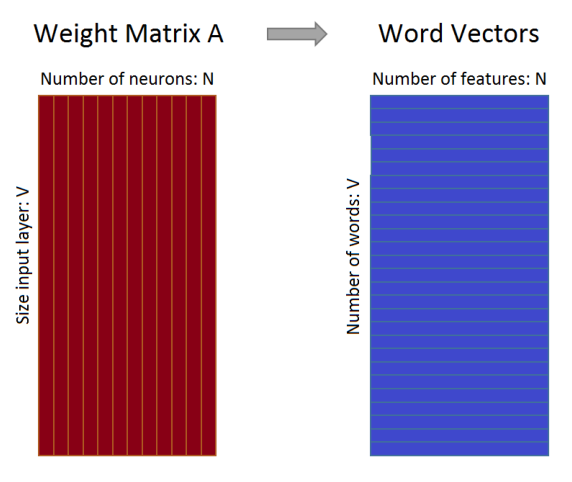

In [88]:
word_vector_length_png = b'iVBORw0KGgoAAAANSUhEUgAAAwcAAAKKCAYAAABoASf9AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAEX6SURBVHhe7d09aFxZezjwOyYk/ImTEAIJSWkkg5ctXMudO2lTrJst7GILg1xKGF5I4C23WzByOgtcvIVdbApvkZWLJK4iQToXyxosx2VShXy8TpEU1v8+Z+6V7ozme858aOb3w8f36mt0NHPnnvvc53y0zkoFAACw9q5VWwAAYM0JDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAwNL77W9/W+0BMEuCAwCW3j//8z8Xx8fH1UcAzIrgAIAr4e/+7u8ECAAzJjhYG6+LR61W0UrlTvH0Q/VpgCtEgMCV8eFpcee83X1UtsJwNQgOFqXjpDHvi/WT4pfTapfVs9BjC2ZPgAAwO0sYHHwont6pL2zK8micWLt5d7xV3BnrqqjzZ8f6tRP48NMP5SV67aT44SdXcB1ePzp/Lc5Lhhflw9M7lx531q/1vF2VY+v1o87XIcfry+r7vd/7vbQVIOS2Hm3vldJxo2eK58YNI8a0hMHBRnHzy2o3HP44eiru9Y/FYbUbTn74qTzdjejD++LnarcotoovNqtdBmtexN95OvrzPcTrH5uvZOVwZ8xGp0t5gvx2/+KyuXb445xaoxk9V1fT6+LSS3z4nUaLof7oj/6o+Iu/+Iu0L0DISdu7dDZuFp0vyWRt1evv9y9uGG19U3y1Ue0vM+3lQi1lt6Ltr3ervfBz8X7Eo+LSBeXJD8WoN0077rbO4c2z8dU35WmwtlV8cyXerYs3VqPTpeMEucKuxLHVdTHRJoPGaP7kT/5EgDAD69D2Xi3bxa8OLs7mYwVs5zpvxGx981UZBsJgyznmYPvr4uIUNeoFw4fi/cXth8qofes/FD/90Lhs/PLm7N88G3vF8dlZcZbKcbHn3drf7u7F8XCyX3w/0c2T5gmyfLxmG7hqrsCxdXExsVUcHDTe7VMEf6wXAcIMrEPbe8V03uw5LMZOHnTciHEjktEs6YDk7aJ5A2OkC4YPPxXNc0xttDTcafFL42d3v96u9lgOX3ccD5OkVj88/e7iBLlbPl61ywJ8eFp8dx4bfFN8tde4IBnjjuO6+Pjxo1KW//zP/6yekQsChNy0vUtn46vim47kwXjtX0dWR2aGEbXO4vbiEoqBo5vn/cN3i6OzZ+Vpa4Don7bTfhNsbW0VJyeT/exI338lxaCvnfML5N2js+JZjj+y+dxtHRSnx3tZ7vzEYNWLl+SoOPv6x8ZrtFUcnI5zRzwG2m0W7cOp/bM3v+96/CxPxhAzeq6umuZ7e+vgtDguX8hLr/c8Xo8r4q//+q+rPcKf/umfFn/2Z39WfdT27//+78W//uu/pv2//Mu/LO7cuZP2GZ+2N6MYCLxZd2ed/O/rfE3Gaf862/36fHslaC8XakkzB+On0prR8ZffNH92eL/JD82c6O7XI755u2Z2aJTRBs02Z2gYZfaAzhkdhpVxBu72msFn4EwV8aatv+/8xF462S82m48RJddAou1fFRddL8fsm/76+yowKE1052TIcz+z56r5extzZDcfs/tryaBjq+tvGTb9RcfvyjHLRbMbwUWKu6Ov80T9alff7//+7ytl+d3f/d3qGbkgg5DP8re9cVpqnMM6yqjnqEnPrZ16tp0zWM+g8zUZo/3r6FK0W/x6pMBg2mubLl0zLl2UHs9T5muLZThOeh8jg39mGSxtcDBeKq2zP/nXe82fHfZG6uzzuDXCVAntA66+E33Zyf5mevEHXnd1zNAwWPv3XUT/ozgZpcNn9aa9uCPRcLhT/s7eb6COE/owJ78UeZZU2Ci+ahwQ4/RNbzZeu78e4+7D+UltyHOfnqver3fu5yodC82TZtLVgA88troHuO0MOE7LRuK8/0/cvPnN9OMXml0QmoFaR1/nCfrVroEbN24oZfnjP/7j6hnpJEDIZOnb3kaW8ZKTYn8zvmf8C6+Rzq21QW1n+TM75demmlmvW9drMmr719GlaITgK8u1zbnqwvo8c9Kt/Tw1X6tc7eVSHCdVANH7GAntv3+053L+ljc46LoYLH5+3//N0LwY2vqi2BznQrKjv+SwwTrtiLr/AdfpcGf6Fz4OxFF/X9PQE+2P5YHb901bizfQ5TfPRsd8d0Ok1yOPjb1fX1xAjjowuTyJX1zflo3XODnd01+GPD+dDncuB1M5n6v3T+9MdCx029j7TSMLU9b7u953YD48/bbRSIx612mw5swknYFaZ9AyybgSECDkcPXb3vaF1+iZzrHOrREYDG07o4kqL6S//aH6aFpdr8lIY7M6ZykaPJ4j97VNBAaj3tA8LL6rXqjp28slOU7iGBm9EktpiYODrgNlwJuhecFRT9PV+bMD7sg2LwCHdDl5/agzoo7+e+0ZYRrl9KCR/os30RSpo44L21L0u+v4facdF3lxAXdUfW1Yv8LDw4sHjvEHF495dHEBnly8cc9tP7v4/qPGd1+qX1my9hPsHCw3ygVkxzR5Y6Stk80vqtcy+nh2/V1VOe14AcpgqjtiyfZcHRb75wffxevcftyj8YKe8rfs/bpRlzLQ+rb7NS6PveaaELtHOfoCvy6+b/wN3XXuSJ3rWsSEBAjTW/a299I5MJXu9rA8H387SrfWcc6t5cXnt12BQYyRav5M8xrg5KTze6fQcXOsfNShXYu6uhQNaiPyXtvEBXpXYND9HJWl2Ryem7K9XJbjpHPa9F516L52WD5LHRyMOq3a6fl0B427DyN2U2im3QbO/9txod6+WOx5AZ6mkWwefD0urkfUuXBJrwE55UXe8TS/q33Qdo793C6edQUI43ThmbXOvunDFs1qXoyWr9mvBpwdezmfErT/4K+NvePON/msL2rTSbLrQn17e/wL9/Ik3Dz3nux/31HvjmOvPLHnGbzeaKx6BWodqfPJ3zcgQJjS0ra9pXSh2etmRbSHXRddvW589DPKubVrZqZ0Ed19cqzajZ4Xv1MZbyapkbsU5b62aY7xK/V8jkrbz6Jt7b4ZOYWlOU6aGZt4PnvVIZ7O4xQkLOvcG8sdHJRPaceboWc/+uYL8WVx8/yYHuUuc+f8zF9e/PAlHXdIhva97rwzO9nFdWfd+veV7/pdo00uXYrAoPdBG89dR7/0bOMGMhhnYHLzYnSGU7h1DhabpfJE85t8mZjtZ80T82GxU+eJXz9qpE7L4yTT2atj7EfP21hjdEmAIQQI01ietvfSTbIh56PubpOjnUdGO7d23xEe1NUyLn5zBwgdN8cGdi0avUtR7mubjqCkfL1+M/AB42bk8J4Oo1im42QVLHlw0PVm6HVXttnnsSs67vjZXv0mO+4CDEq79Z5hZaDzLimlqS+u8y8pvzukm8hYff/matQLyA8dg2nHGog8ldFXFR3X7lHuBc3KE3Oz9UqDk18Xjxp9JbcOfjXwOBlds7Hq/17rCLSsecCUBAiTW5a2txlEjLa6b+cF7Cjt72jn1q66jHBu3P5VZ1ecqY2Y0em8MXZQ9E+a57626QxKRnu9clim42Sz+OLiCRqxy9LyWfrgoONA7JGi7Ih6u6+gOw7iyxcao/dHby7UEoN02yPhB5YRBiyNbvBqk2ON8B9Vx/M+uwveSXReQPYZmDxy4zO6vlOSZX2t56wjExPxQaOv6NC7PmNoNFYDG9WNveLifD1Cv1oYIgKEP/zDP0z7ESD827/9W9pniGVoe8catNwwk/arc8G2QdmO2Rmta9HIXbZyX9t0zJQ3xus1raU6TrqDjvY0rMs6K1E/yx8cdE3h9XPXq9ezz2Ot42cvX2hc/GycnwZcPXYc8POyUTRv3vcffDv+dHBXXscFZO/npplinO7ud3v2gzgp9p+S7CorT2S/6XV3K2f6tJnFGX7ibt51HC3VC/3FAmn//d//nfZjgbQ///M/T/sMsQxtb4dm16UhNm6W310bfHNtZF0XvotqajuyMj2zq82790POtwu5tpm1BR8noWtMX4gZnlJwlWvtpxlb/uCgvDzp342kX5/HWtfPdrzynW+gmb7RJ5zOsyMlGXPp91wkqzk6f4yI+YrrTHl3D0we4+Q4UPfzu6K6LgKSnGM0Ou7qjHB3qjkFXL/MEIzAysnTWIK2d8zppNfCsHF3cxprlwy8thnjIn1aS3icpAHXXTM8JVUmwSJoGfTthzxs9pNSR9/5Zr/JZsQ81hsoRp9fTEc1Upl0Os+uO+QXB1VdOqcLy7JI1VUxoO/lh6ffNY6LX0/8nLx+1D1Pc+8pyXqeAK6SrtklkvJYG3n2hiE6uhBMYJQpa6GbwGB6C297O7p90DZ43N3oXYq65b62mWN35GU9TqqZqy5PnxrGW2Nh3q5EcNAv9dPsa983NdlnWrWO/pLD3kAdv3+OOmaNGWL3KMuI/6ujc0ali6k4O7tZjZ6y7ta8uxWBV8z7PHgQ99XUNQB5q/mcfpvhxNX5ekxk1tPDsnIEBpksuu3tMMbF5iy6AM2qC8oE+o+7GzNrvqhrm5la8HHS00aaPjUCqktrIy3pgOWrERyUl2QdvUjSWaZzlH3/F7XzZ9v9Jscdod85+nw+gySbF23tO9Y9p0WLKbsiMl3WyXJnqOMEWTc+zbvgA2dpGKLrpLGq3bU6siMRYB53LrQz9Ymra2B4z8xLr9KRjbk8GBL6ERjktOC2t+uCfNS2tzNbmat7S/M6oP57FqSrK+h5dnXsLkWZr20mfL2mtlTHyWBpfYPmxVzPcSOLd0WCg7gJ0XGWKU8xjVH2Q94Em413dDsF1xyhP8oB0Tk4eC6DJJsXp1Xatr1oSFeZtMvSKuhxgpw8pbqGOjJTW9UicV3Tm07Z579zMbVBM4J16df4wQACg/wW2/Z2XpCP1vZ2ZSvHOe8MNO51QI/VlLPp7FpUniBTdrVjLZmRpu/OfW0zyeuVwzIdJyPo6ha9yCxUP1cmOOh4MiPSetqIkL+8OfBNcKnfZPNnRzwgOmcIyNcfeyRDVwJeEnOPgLumDDvc6bjYzXe3f8Cb98PT4s4kU5ku/G5B5zoQHeNVumZa6L9M/jCdXbPG6+LV3fhdkffADH38+FEpy3/8x39Uz0gngcGMLLTtvTwt5LC298PTbzsm6Rh7ZfwBRr8OiFnuZjuZxeXMefN8O/r03XmvbbrO20Mfrz0b4J1hv3Noe7lEx8nrR8MHG8+tO9Pkrk5w0JX+2t+/uOoYetHRNa3aWD9b65oP/mR/c/ABEBeNadDwhANOuus8bIaXRU2i2zEQqKxn123m1+UJa6Y6IvCGKQYiJ913rncuz1Oc1j0YJzBY9HPV0HlivLzSZ+fiPY3Vk8fRTHGP0VjVOhu/Oaaol9T//M//KGX5v//7v+oZuSAwmKWr0vbG7HJdU05P2w5062pvoi6XLmzTxeEcZrm71EY1u4iOcRc887XNxl6za2r1eD3aj/a6Qe3nqecK3OO2l0tynLTH48Rg4/I56jVtafcNxbEmxJmjsyvk9GDrLKrcWbbODk6rbxig98/unh1VXx/N0Vl50Pd4nMFlt9cvOT04K4/j6nv6/Q0T/L6tg7PeT0fnY/WsU9NI9QunZ+Ub8vxxL5dxn+O2o93GYwypbMf3VmXY3zfS4x/tdjzmaCXnczXma1Yb9tp1fL3/43a+Z0Z7nzWN8xr21vV89T22V9u//Mu/KGX527/927O/+qu/Onvy5MnZixcvzsvf/M3fpM9H+ad/+qfqWSOnhbe9XeeskcrA88WE59YwRruwdXDUOIdN1hYO1Kcu459uM17bhHHbzp4PNMG1xTIcJ2P+7eO/VvNxpYKDni/8qBcMvV6wiS42xn0T9TmBDruAC5Mc6FF6/l1jHuSj1K828M0w++Dg0vM0wus66uP3btg6S/z4xePlfK4mbMAGvnbjXHB3HevjvF+6XpOR695l2gCF1fH3f//3l4IDgcGc9GqLRj0fLKLtHXrCmfDcWhvhArD9mM3z7QyCg57PyaS/Z4znN5Vp2rpmGVDfia4tFn+cdFxfDChjH3dzdIW6FZW60mhh5EGnPbqfjDZgp9t28SwFVb3mrW2q5ww+njBd9bp41Ew97R61ByD3LEedf9vJsEGkmfu4bT+7XIfK7tEcpv/sOi5GOSaaA+UGSTML9Pnb6tdkrImiFv1cdaxpUB6jA1dBnmJwcseiNON3Kap1pqh1LeKCrkRztFRtb5/zcajbyVnP3pfO432uASZpFybWOSNUMvHA2szXNuk56p66s6GeaXHQFOETtZeLP07ak8f0fx7bU6PP6xiZTKusYEQwLJnXj1oXg2vjQB56FHUOgIqDb73WPQBW2T/8wz8U//iP/1j86Z/+afE7v/M7AgOAGblamYO18aForDEz+sAtgBX3X//1XwIDgBkSHCyl5lzQI+pYbCpmmJM1AFbP//7v/6atwABgNgQHS6lzQY+YRnPQVKXRBaljSs1pVgYGWHICA4DZERwspa4FPcLhTtFzfYOyXCz8FYYNMgW4ugQGALNlQPIyi8VUOq/8h9gtjgaN/Ae4omJA8v/7f/9PYAAwY4KDq6B7Rb1uMSXYsWwBsLp++9vfFn/wB39QfQTArAgOAACAxJgDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcLJ3XxaNWq2i17hRPP1SfWkn131mXVf97AchPmzmYtpbxXfng4PWji4P+zoAj/sPTO+3vu/O08L5YtDhZ7RSH1UdtJ8Uvp9UuV4r3IFwd3q9X0aRtprZ2WS37+/CKBwcfivc/V7ulk/1vRcRXwesfq5PVbnF0dlacVeXZdvokV4r3IFwd3q9X0qRt5pK0tecXuI9eV59Zd8v/PlyxbkUnxf73Dr5l96F+V+x+XYgHVo33IFwd3q9XwaRtprb2qli+9+HKBAe7BwfFVuwcfudOCCyA9yBcHd6vsHjL+j5cnczBzb3i17uxU0Zg347RN+vD0+JO6vf1qOgZt/X9ej3Ip/78sEE/3V/v8/suGfa4lzX7sg38mfpvq/qynaf+ooyR/uv4ubr06B9X12tz/6T9icOdi+8f+vu6nu/z16Uuw5/PsZ+Xfo/Z7+tjPp+jPm9t0/39o/7tF3Ua/nxeMul7EJg/bea5VWszx/25kf/+Ss/693h96u/rWY/m75j0mBrz9Rj37xz1+y9+76jHaMOStpsr1a1o+1dVBHayX8w1Q/P6UXlQXB70s7/ZKuL4bB843V8/LHaGHJjFT4Mf95LqjbLT+QOl9s8MGvTyU/kmOH8Dh5/fj3CQtk/CHT9XK1+DzWF/34Tex/O5uV/+VU0Dns8pnpdJDX4+p3vexvv727+r999++ftPf6kf9efi/QRPy8Leg8DYtJnr0Wb2Ne7fX31/z/qn16fP8zwHA1+PsV9n7WYMTrnCTs8Otoqz+DN2j9qfOdptf1xsHZRfvXB6sNXz8+UXzsoXpfza7ln1EJ36fv3orAz22o956evdX+v6+vljlqWu+LlBj3vx916uT+Nr/f72YuvsoPMLF/WIcqkugzTr0vW4HX9Ddz0b9Rnr9434fF96zGmel8t1T/p9faTnc9LnbbK/f/Bx3/37G9/f72+/5OLvqX/12O9BYE4yvF8nPT82z1OXvt79ta6vN8+tl86rgx63eb7trs80bUNVep7j+5n03N+oz1i/b9jPTf73b3U3HAMeKwyt/6TH1Eivx/h/5/nnex7769Furlxw0H7xuj5XGvxix/ePeVCWHw16M5evdPW1svR4Ufu/4I3H7XkwXHy94w1a/74+B1B94HX8TPON1efn+jr/+y6/Udr61LN0/rf3O1H0NOR5Oa9P12sx1fMy5jExyvM58fM22d/f8+/LKsN7EJgTbea5qdqG/j/X18Tn/sbfPlabOeTnJvn7BxlwXAyt/6TH1CivxwR/p3bz7GzFZisqbdT9t4ri8Lv59N/aPXp2eSaAzS/aaaLy/4Pf7BUbaf/CxlffVGmkX4reUw73/rmi/E1fV3/fSWOy4tc/tvNfW9981eNnyp+qfujkh596PCf9fld/9e8rdn9d7PX8wd71nF6fup4/351pvemel0n1fz6nf97G+/s3v2h/9mT/+2Ju2coFvAeBCWkzJ2gb+p/j+1lcm9nbYtrGWRne5o7zd2o3V24q07btZ0dFeo4X2X9r42bxZbWbW33gXvSpu5gz92R/s+gcQFOVy53nGr4sbo5zlmv8vq0vNts7PVyu5wz1fL6nfV4m1e/5nOHz1ud429j7dfu9UPUHnWjA1ASW4j0IjESb2dUuRFnpNnPKv7/qw9/x/ZfGwc3T8DZ3nL9Tu7miwUH5FBe/Omi/ydy5nK0vB5whN27O6lR/9c3vedsunp2dFUftM12pPtnNeuCb9yBcHd6v83LV28w0g89CA4F50G6uaHDQiPxW+c7llzcvpcm2Dk7PV0HsWY7HS4UO8/OAofnnC7AsgXk/L8PM+3nbflb9nednuwEzeGSyFu9BWBHazD5lxdvMsf7+14/OZ/C59HOn1Yw7S2qS13md282VDQ66I7DhPfgmm4JqES6mzaptFPO94XDx+wb1jTyvZ48T8nxM+7zkPiaW4HnbfpZOdvW57vDHWZ59xn0PAoujzZydZWszJ/v7L8ZNHBXHvQdOTGl2be5U1rDdXOHgoDwsGhHYdz+kT1123s/xpOj1nn39/aLSZ2WE2its/PC0+K5+f359MaTrfFDNnAbQnPeNPPyxz+97XZyfRxr1nLeJnpcZHhPL8rzVz8us+7aO9B4EloI2c3aWrc2c5u/vOW7i9Jfhr3u/9maGx1TO13md2s2VDg7Kl/I8Ajs56XdoXcwQcLjTHHTyoXh6p9ciGHMUqwl2rJr4unhU9/XbOih+1Tx/bH/dPphS37geg2eqAUS50mHnB2/P3xcLiFQL0XTXc94mel5md0zM93lr1/fySpHl76n+iO4ZHKZa6bGnUd6DwHLQZp5b9TZzgr+/DnBO9r/t6Huf2o0BL/z5WIqTH4qfel5Vz/CYGvvv1G6GFQ8Omm/I/s5Xp0sHT7zAUTaLWGxv6+Bg6M/PRHmCOIqDo4wcN8/rVK/82Gvaru3i2Xmfv+bfUZXsA4gG/b66nrvF0Zz78l822fMyu2NiAc9bx5L1nb/n112p4Yv0e7707ijvQWA5aDOrsvJt5vh//8Wx0e57X39ve2XirWKr/WCXnV+gN3+uc3DvYtrcsvR7nde83Vz54KDzwCj16su3sVccn1VTSJ0rTyanZ8Xx3s3q4/nb3DtuDISplSePs+Pe8ySnv+O0qALOLvFzZ8WznHckBvy+9uCfHnNZL8Ikz8ssj4m5PW8bxd5xn79796jn7zlPffedGm4SI7wHgSWhzWxbgzZz7L+/PDZ6fX9qT35TfFN9eFn8XPfx0tXGzPKYGuvv1G6G1lmMsgAAANbeGmQOAACAUQgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAABJ66xU7S+9Vw9uVHvAqrn34mO1B+Rw9/Hzag9YRW+ePKz28pI5AAAAkiuZOXj/8lPa5nDz/vW0zfWYuR8vqGMe6pjHrOoocwB51ZmDz+9upy2wGq7depu2MgcAAMBMCQ4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABA0jorVftL79WDG2n7/uWntM3h5v3raZvrMXM/XlDHPNQxj1nV8d6Lj2kL5HH38fNqD1hFb548rPbykjkAAAASmYM1vlOrjtNRx7x1lDmAvOrMwed3t9MWWA3Xbr1NW5kDAABgpgQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAASeusVO0vvVcPbqTt+5ef0jaHm/evp22ux8z9eEEd81DHPGZVx3svPqYtkMfdx8+rPWAVvXnysNrLS+YAAABIZA7W+E6tOk5HHfPWUeYA8qozB5/f3U5bYDVcu/U2bWUOAACAmRIcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgKR1Vqr2l96rBzfS9v3LT2mbw83719M212PmfrygjnmoYx6zquO9Fx/TFsjj7uPn1R6wit48eVjt5SVzAAAAJDIHa3ynVh2no4556yhzAPnV2YPP726nLXD1Xbv1Nm1lDgAAgJkSHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSts1K1v/RePbiRtu9ffkrbHG7ev562uR4z9+MFdcxDHfOYVR3vvfiYtkA+dx8/r/aAVfPmycNqLy+ZAwAAIJE5WOM7teo4HXXMW0eZA8ivzhx8fnc7bYGr79qtt2krcwAAAMyU4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkrbNStb/0Xj24kbbvX35K2xxu3r+etrkeM/fjBXXMQx3zmFUd7734mLZAPncfP6/2gFXz5snDai8vmQMAACCROVjjO7XqOB11zFtHmQPIr84cfH53O22Bq+/arbdpK3MAAADMlOAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgaZ2Vqv2l9+rBjbR9//JT2uZw8/71tM31mLkfL6hjHuqYx6zqeO/Fx7QF8rj7+Hm1B6yiN08eVnt5yRwAAACJzMEa36lVx+moY946yhxAXnXm4PO722kLrIZrt96mrcwBAAAwU4IDAAAgERwAwAy0Hr0uyn9F+Q/gyhAcAMAsHO6U/1rFTuuRQAG4MgQHADADR7tFUf4rHV4KFJ5+KIryH8DSERwAwAxsPzsrnp0dFWdllNAdKOxv3ik27zwt7pRRgkABWCaCAwCYme2IEnoECidFcbJf/tsUKABLRXAAAHMxeqBgfAKwKIIDAJi7wYFCPT4BYN4EBwCwUO1AYbMMFL44PSq2traqzx9WW4D5ERwAwILE+IIYZxDjDaI70f7md8XJyUn6WnsAM8B8CQ4AYI4uBwR30niD6E60VZwUB1tF6mYU3Y0A5k1wAAAzNkpAcFr+d3x6UOwdn6ZuRqm7EcCcTRQcWOkRAIaLdjLay1ECgo2946L8r/yJjfSzAIswWebAkvAAMFC0j9FORnsZAUH5XxpHELMSCQiAZdU6K1X7I3v9qFX8GIs8Vh+3xRxsXxcHv9ouvirPcbM4zb16cCNt37/8lLY53Lx/PW1zPWbuxwvqmIc65jGrOt578TFtYVW0WmVQUIqA4Ovyv+32f+VH8+kudPfx82oPWEVvnjys9vKaKHNgSXgAGCzax3pgcbSbxhEAV8FEmYPLol/Rj+W/w66Mwlb575vy31fFN19tTJ1RkDlQx2moYx6zqqPMAeRVZw4+v7udtsBquHbrbdouVebgssErPVoSHgAAlt8MpjIdHChYEh4AAJbTDIKDpnagYEl4AABYfjMLDi4v+GJJeAAAWGZZg4PLAYEl4QEA4KqYOjgYJSCwJDwAACy/iYODmHHIkvAAMJpoN+Nm2rAZ+0b9PoBZmCg4sCQ8AIwn2s24mTZsxr5Rvw9gFibLHBzuxH/nAUHHCpACAgDoIWbqi4k5hs3YN+r3AeQ3UXBwKSAwjgAABoruttF+xnaQUb8PYBYmCg4EBAAwnuhuG+1n6nY7wKjfBzALEw9IBgAAVovgAACWREwPDrBIggMAmJOYojRKt5gaPGYCjOnBY90g05gCiyI4AIA5iKAgpij9oSxN8fk0NXjMBHiyn9YNMo0psCiCAwCYgwgMYorS49Nv2p+otD9/MRNguSkdpkwCwLy1zkrV/tJ79eBG2r5/+Sltc7h5/3ra5nrM3I8X1DEPdcxjVnW89+Jj2sKqarVaadtsduPyf+fS51+X3xvrCXV+77juPn5e7QGr6M2Th9VeXlkyB3Fyi7TosHsco34fAKyDuvtQZAwumCYcWJwsmYNWOrn9XJYvi7OzWP+gt1G/rx+ZA3WchjrmMas6yhyw6urMwWnZ7G6U295Zg7ZeWYZx1ZmDz+9upy2wGq7depu2S505GH2pd0vCA7Ce6uRAPSNRnTXoSBoALFiW4MCS8AAwWKx6nOKAakaiuFEWH8fnm+qByJpKYBGyBAeWhAeA4Z6dHXXcKIuPux38vJMCg73j0+ozAPOTbSrTHmu6AAAdtrtulF0efBxBQTswiJEJAPOVJTioV3UEAKYVQYHAAFiMPJmDalVHAKA9E1GOAjBv2boVAQBtMRNRjgIwb1mCg3r2oeheZOwBAOtuqzjsW9rTeQ/+2sFWuwDMW57Mwd5xcRDzsR3upLEH9SrIgwoArKrj04OepdhNk5mm2Yp6fb2evvSHb47MVgQsRJbgIAKC/Z/Lk1442S/2N+/0TI82CwCsrI29S+XR6V5xchgZgWptgx7fEwFBhA8n+zvFa4OSgQXIEhxslQFBKrGfysl5irRfAYB1crjTStvBGYGN87UP3EgDFiFLcNArNTqsAMB6GpYRqNc+cCMNmL88Yw56pEaHFgBYQ8Mm7jCxB7BIeYKDLnFiqwsAUKSxBCHG6fWbmCM+Xy8qWo1NBpirrMFBzFJ0p/wvTmx1aXpUnvWiAMC6ibEE6YL/ZD+NJ4jpv6PNrEt8nMYZVIuK6oILLELrrFTtTyVObCf735Z7J+1PVJoPf6fVSl89Kj9X96gcx6sHN9L2/ctPaZvDzfvX0zbXY+Z+vKCOeahjHrOq470XH9MWVtqHp8Wjzf2Bowkiw/As5jrdftb+xITuPn5e7QGr6M2Th9VeXlkyB2VcUAYGm+XeSZq7+Sz+66G+C2IGBgDW0sZeyiBEOxlNZZSY2jRK7Meiomm2oikDA4BJZckctFp3yv9P0kltY++4+lx7yrbuh+/3+VHIHKjjNNQxj1nVUeaAdRBj8S7PVVSP0Mu7rkGdOfj87nbaAqvh2q23abvUmYO6K1EdGAAAnWJMQfdYvLYICix4BiyHmcxWBAB0OdyJPrjVBwDLKWtwMGzqUhMVAQDA8soSHNTjjyNd2i9AiMCgHogcA68AYJ3EuLwQ3YuG3UwDWJQswcH2s7PzuZsjQIhpTWv1/M3twOAwfd/e8Wn6GgCsjb3j4iBuph3upLYymsq4cTaoAMxbtm5FMU1puilSBgjtaU3bYr/98WGau7k9namBVwCslwgI9n+uFjYr28r9zTvpxtmgAjBv+cYcbOyljEA9d3MECnWJj+Pzae7m8vsAYN1slQFBKrGfyklZIqPevwDMW5bg4KIT0UZauCW6GUWgUJf4uL2gyyTrIgPA1ReZ83ELwLxlCQ7qcQbRf7IjUDB3MwC0ReZ83AIwZ3m6FVXjDKL/ZAQKj14bSAUAw8QNtboALIMswUFMzxZjC6L/ZAQKhzutNJAqpmsTKADAhWgTI9ter5hcl7rNFCgAi5QlONjYO05jC6J/5EWgcJimaxMoAEBbdL+NNjHN4levmFyXqs2MQEFbCSxKnm5FyUbqHzlqoNA5PgEAVlu0edH9tp7aO2byi3YyZvOLbXwcn49AwTSmwKJkDA6aLgcKRxElJO1AoR6fcHkgMwCsnmjzyiv/FADE1N4xk1+0kzGbX2zj4/h8ChDKtjLaR4B5m1Fw0BantacfNoo7P31V7PzwTfuTpQgTdqvxCc2BzACwsqLrUCmt+dN3au/t6uvx7RcLigLMS/bgoB0QtAdbxQV/XPinE1x5Uoy7IZE2jUxCnPwildrudtQOFABg9Q1b88eaQMDitM5K1f7EIiD4qfzvh/K/kx9+Ki/0fyg/U17wlyIg+Lr8b7v9X/lR90mv/MEPP5X/fminVwd49eBG2r5/+Sltc7h5/3ra5nrM3I8X1DEPdcxjVnW89+Jj2sKqarVaaTtKszvO9/Zz9/Hzag9YRW+ePKz28sqSOejOEEQmIDICkRmo+1X2XyH5YnwCAKy6YUMJzFQELFKWzEHc4YhxBN+U/31V/rfx1TflBf9X5Wfyro4sc6CO01DHPGZVR5kDVt2Hp3eKzf3Iqm8VB6fHxV6PJjICg/ZMRYfpJtve8fSZg8/vbqctsBqu3XqbtkudOYgp2GIcQcxMlDIAacn3vIEBAFxl0T5GV9vodhvZ9pjWO8bnxRpA9aJodWAQN9yiTQWYtyzBgYAAAIaLrrbtmb1P0rTe0R031gBK3XJjUbRqDYS44aZNBRYh62xF0Y0yUqKjFABYP9spIxBj8mL2vggU6hIfRyY+TWWabrgBzF+24CDSojEwOVKioxQAWE8baZKOmKwjAoW6nC+KZipTYIGyBAeRCYi0aHumougreRifSeXSx1sxyCr2AWB9xJiCuJHWmT2PrkN1AVi8LMFBnQmItGj0k2z3lWyrP44Uajg52TLICoD1c7iTbqRFm1kHCjGt6ZCZTQHmKlO3onYmIF30Rz/JZl/J+uPtZ6kvZQzCaj0SHACwXuoxBimbXgUKMWtRdMmN2YoECsAyyDogeVha9HyhszQjAwCsj3qMQZ1Nj2Bhtzgptk7202xFdaDQu/sRwHxkDg4AgP42zrPpESzEzEQRLERm/WDrpNgtA4Vm9yOAeZtZcBAdiEKkSmuNXQAgZiYqg4XIrH91fFp8cXpUbG3VLajJO4D5yxIctMcSdAYC9aDkSJXWq0BGyjRU3w4AaytazGg2owtRtJObd34q28nvipOTk3SDrT2NB8B8ZQkO4o5Hut6PFR5rG3upP2Vy2F4FMgYjx6fMVgTAOopxBBEMxA2zGF8QN83SVOBlOxldio52T9INt7jBlhZDA5izbN2K4kRWZwtq0Z+yHnQV5XzlR/M5A7BmIjsQ4wgiGIgbZhEMxDiDaBujrYz28XwhtBiXYDE0YAHyjTmIE1k6mXWpBl2dn/Cc7ABYR2mmvvY4ghhXEOMLbh6fttvGsq3UPgLLYGYDkgGAC5EhiCx6dK+NcQUxvmCn9f35uLwYf2D6UmDRWmelan8kcfLKYW+CnkWvHtxI2/cvP6VtDjfvX0/bXI+Z+/GCOuahjnnMqo73XnxMW1h9ZQjw+sfiw/ufi59+OCl+OTnPJ5TlyzJ6+LrY+mKz+OarjYnaytrdx8+rPWAVvXnysNrLa+zgoNVqzzg0rbOzakG0MQgO1HEa6pjHrOooOGA9xR23077BwiRtZU1wAKttaYKDO61WtTed4/F+bSI4UMdpqGMes6qj4IB1Ft2J3pdxwg8/vS5OfvmxjA7a4cGYTXSHOjj4/O522gKr4dqtt2k7q+Bg7DEH9axE0xYAWFeRL2iucRCzGMW0pif7OykwiHEJMT4BYN7GH5Bcz0o0bQGANRLZgX5rHGwVERCcpICgOa0pwLyZrQgA5qC5xkH5XxkQnBQHW+1ZjCKjfh4QmNYUWCDBAQDMxUV3oTog2KvXOUgZdQEBsHiCAwCYg96rIE8xVynADAgOAGAedBcCrgDBAQAAkAgOAACAJEtwEHM1RxlFfF9M5wYAACyXLMFBzNUcZRTxfTGdGwAAsFwydSs6qcoo4vvay8IDwCqqVz8GuGrmNuYgeh2N2vUIAK6y89WPG1pltBAFYJlNHBzUJ7nmia75ue5SLxUfYhEYAFhdPbLphzvtArDEJs8c1Ce55omu+bnucrJffsNJCgxiERgAWHXyBMBVM3FwEEu/16XW/FyvUq8OaREYAFZZnSGPCTjqDHqtmVUfVgDmrXVWqvYn1mq1+1VmeKiBXj24kbbvX35K2xxu3r+etrkeM/fjBXXMQx3zmFUd7734mLawGl4Xj1o7U0+/MU27evfx87T9/O522gKr4dqtt2n75snDtM0tS3Dw4Wl7LMHG3nHazorgQB2noY55zKqOggNWz+vy34/Fh/c/p48299vjECKTPqpp2tU6OABW06yCgyyzFcXJa9aBAQBcLdvlv2eX2sj641EKwLxlyRxM0ityklEHMgfqOA11zGNWdZQ5YNW9ftTugrv9bLZdcGu6FcFqmnW3oiyZgxhwNW4BgHUSQUF3YBDL/9QFYBlkCQ62isOhpajKblUAYB1Ftv3O0w9pNqJYA6gu8XFMUCRQABYpS3BwfHowtBxV87r9fHBgnQMA1lIZE6Ts+cn+5sUaQHUpP45VlSNQMIkpsChZgoNiY29oiVRqTNBwsr9fnhytcwDAeomMwP5mzO4XGfQi3TSr1wCKbXyc7qOVgYLut8Ci5AkORrR3fJq27ZMjAKyPyAiUV/4pAIgMetw0SzMSVTMaxcfx+RQglAFEdD0CmLe5BgdFsVFt23M9A8DaiK5DpXbX2n4Z9O3zrrep6xHAnM01ONCHEgCGda3V9RZYnCzBQVz0DyqRGY0ZGOo+lO2UKQAAsEyyBAf12gX9SowxiBkYog9lLBpvtiIA1tWwoQRxUw1gUbIEB73WNegs7QFYMRNDTGsqZQrAuokZiULcMOsXIERgEDfVQvXtAHOVJTjoXtOgV6lnZkhTmwLAmokZidrdak9SgBCLnsWMRNHttl4UrR0YxE21ixn+AOYpz4DkrjUNehbZAgDWXNwoa2cETtKiZzEjUXS7PV8UrQwMIoCIm2pl4xnfCDBXeYKDHiJjaoZmAGjaThmBWPgsutpGoFCX+Di6HqVxeemmGsD8ZQ0Ooq9knRqNxV6ixH6USJsKFgBgo4wRnqWuthEo1OV8UTSZdmCBsgUHERREX8nz1Ggs9hIl9ssSadMIFvoNwgKA9RNdh+oCsHits1K1P7G44N/fjKlK22sYfF3+t/lF6lSZnP5yUnx3mHpYlraKo7Pjie6LvHpwI23fv/yUtjncvH89bXM9Zu7HC+qYhzrmMas63nvxMW2BPO4+fl7tAavozZOH1V5eWTIHMetCiD6T9axEkRqtS3wcg6sicIgQoZ6mDQAAWB5ZMgetVjtrcHYW064NSo2+Lr83ZmOI7x3/18ocqOM01DGPWdVR5gDyqjMHn9/dTltgNVy79TZtlzpzcGFYn0mDrAAAYFllCQ7a3YWGL/luLDIA60w7CCy7LMFBmpO5FGMJBp34YraiEPM7A8A6qaf5BlhmWYKDD8V2cZou+A/PpyvtLnFSjKlNd3e3iqebz3p+DwCsrHqab4AlliU4iIBg87sv2h+UJ76Yvai7pJNi6fCwPbtRrwIAACxOnjEHkRGIEvupnPQog77WLgCwqk5jvu9SZNIly4FllW3MQY4CACtr77g4SD1wd8674MZEHoMKwLxlCQ7aU5TmKACwmiIg2P/5oP1B1QU3JvIYVADmLVNwAAAMslUGBKnEfionZTkcWADmLXtwEGnQ7lmIehUAWCfHpwdjF4B5yxYcxAV/DLKKNGj3LES9CgCslY298QvAnGUJDiJbkC7403SlkQrtPRtRswDAOoskel0AlkWW4KA9aCou+turH0cqtNdsRM0CAOsoMu13yv/SGkFVaYo1Q6MALEKmbkXtQVPpon/7WZUK7TUbUbMAwHqJoCAy7Sf7m+3VkuvS8PNOqzgsi/gAWITMA5Jd9ANAL5ExSEFBcVIc7bYz7b3UA5FNZQosQpbgoL3mowVbAKCfejKOWCl5+9lZkTLtvZwPRDaVKTB/rbNStT+5D0+L1makRXeL07NnxUb7s9m9enAjbd+//JS2Ody8fz1tcz1m7scL6piHOuYxqzree/ExbWFVtVqttG02u70+F/p9fhx3Hz+v9oBV9ObJw2ovrzyzFW3sFQcHkT84PF8SflgBAACWS5bMQeu8X2SdAq07GvV3dnZc7Y1O5kAdp6GOecyqjjIHrLo6G3BaNrt1hr1XhiC66O5kzBx8fnc7bYHVcO3W27Rd6szBbhkUtEvsR7m8rkF3AYB1Uo8/jgx7vwR6OzBo33BLCXmAOcsSHHSvYTBKAYB1EoOQ0/X+yX4KEGJa01rsR2kHBrGYaFHsHZ+mrwHMU6apTLvXMBilAMB6iWlKU0agDBDa05q2xX7743YWvj2d6aym9wDoL1NwAAAMtbGXMgKxxkF0M4pAoS712gcpu34+nSnAfI0dHEQWNJZ1b844FPvjFgBYTxtFrHEQ3YwiUKjLxdoHsuvA4owdHMQiLrGse72YS4j9cQsArLsPZaAQRRciYFmMHRxsVTMN1dsQ++MWAFhHMSNRDD5uPXqdBiZHif0okZmXXAcWaezgIAZJRZ/I9mCpttgftwDAuomL/5iRKA0+PtxJA5NTif2yRGa+XkwUYBHGH5Acg6SiT2RzsFTsj1sAYI3EBX9c/NczEsUA5NODrfMSH8dERhEsRPfbyDAAzNv4wQEAMLZ6vF3MTBQzEsUA5I294/MSH0dmPQKHMkI4XwwNYJ4EBwAwF+3xdu3FzfrMSLSx11go9LDaAsyP4AAA5mrYzESmMgUWR3AAAHPQ7i7Unq1oEGORgUUSHADAHNTdhWIswaAAIGYrCjEzIMC8CQ4AILOYmehy2S4ODuKC//B8utLuEmsdxGxFRwdbxYe0WjLAfLXOStV+NuX57VzONR9fPbiRtu9ffkrbHG7ev562uR4z9+MFdcxDHfOYVR3vvfiYtrAKWq32zES91QuBpolLu1Rf22qvB3R2PPnU33cfP6/2gFX05snDai+vrJmDuOsRqz7WKz7WqdFa3BCJAgCrbLe8yO9f2uMPBn7tZD8VgHnLljmIoOBk/9tyr74j0tZ8+DutVvrqUfm5SeZikDlQx2moYx6zqqPMAasl152wyWcuqjMHn9/dTltgNVy79TZtlzpzEBmDtBR8eekf46f6DaKKxV2ChV0AWG1xUZ+jAMxXluCgXvUxln+PFR7L/9LHl2zUfSct7AIAAMsm05iDdleiWP4dABgsJu6IjkfDCsC8mcoUAOaknq40JuyILrbDCsC8ZQ0OmlOY9uIuCADrKtrA1A33cCcG6hVbxeHQAjBvWYKDevxx3AnpFyDESbG+C3LQa2pnAFhh7TbwpLzob4/Ri0k6hhWAecsSHMQg5HS9f7KfAoSY1rQW+1HaJ8W4E1IUe8en6WsAsD7amYC46E9j9GKSjmEFYM6ydSuKk13KCJQBQnta07bYb398mBZ2ad8JybluMgBcIS76gSWWb8xBebKLjECscRDdjCJQqEu99sGzsyMnRQDWUr0CkPF3wDLLOiA5ZQS2n6VuRhEo1OVi7QMLugCwntINslJ0sx02gQfAomQODpqi61BdAGDdbaeByNHNNsbnxfC8YQVg3rIEB3ECe/R6tFRpPUAZANbN9zerxUJP9tO0psMKwLxlCQ7iBHa400qp0ggSBrkYoAwA6yPui0VbWdsqTordIQVg3jJ1K6pPYIfpxBerPxpwBQAX6kxADEyOSTpi9r4YhzCoAMxb1jEHcbJLszEc7pxnEXQgAoDQvpGWLvpjko40e19M1DGoAMxX3gHJ5ckuTnoxdWmdRagHXQEAwUU/sLxaZ6Vqf2KtVrsPZcdDvX5UPNopA4T0wVaxdfCb4jd7G8Vmr+8d0asHN9L2/ctPaZvDzfvX0zbXY+Z+vKCOeahjHrOq470XH9MWVtWjsv2LNvGobP/mER7cffy82gNW0ZsnD6u9vPJmDpoaWYQYdBWDkCOLAADrqB5DEN1ujcsDltXsMgdNH54WT7/dL/YbEy/IHIxOHfNQxzxmVUeZA1ZdCghePyp2diJ/sFvsHsXioIM9myLFUGcOPr+7nbbAarh2623aLnXmILID7XEGfWzspZWSY/GXWP8lrQEDAGskMgY7O9UH1bi8YQVg3rIEB9vPzlIZbKOMEY5TkBAFANbJbhkQtEt7OtNRCsC8zW7MQV8bVQGA9RFjDsYtAPM2dnAQ05LG+gXN6Uljf9wCAOulXrtgnAIwX2MHB7HCY/SDrFd6DLE/bgEAAJbL2MFBTEva3IbYH7cAwDqJ2YrGLQDzNv5Uph+eFsXpL0Wx+UW19Hv1uXHVPzsGU5mq4zTUMY9Z1dFUpqy6VutRtTe6s7Ph0532YypTWE3LN5VpXNRvlyer5sV97I9bAGCNbBWHQ0tMcRqlntkIYN5mOltRjDuWHgWAojg+PRha6jWDfj44MFsRsBATBwfDZh2Kr23eedpe9KUqd0xTBMC66pVF7yqxZlAsFHqyv1+2o2YrAuZvouAgrvEHzTpUf708u5UfXaRKT/Y3i1bMgwoA9FQvFGpmP2ARJgoO2iesk+Ls6Mv2J7rUX98q/z872k2p0tO4FRIOdwZmHABgvdULhZrZD5i/CbsVVSesGJjcpZ0YaH89goJ68PLG3nEKFIK7IQDQm/w6sEjZByTHAmkhJQqiD2XTeTDhbggA66WenKNfiax63GCLMXqhGpsMMFdZg4PmcIK6zyQA0L7oH1Qiq96+wRZj9QqzFQELMf4iaKU7rVa69791cFr8Zm8j9Y5sD0K+yBrsHfd+2Fb5s2GCX2sRNHWcijrmMas6WgSNVRdt5zAxku/r3aLY/tXB5ez7mOpF0IDVtDyLoJXSWIJSzD4U05XGDETNcQSyBgDQqV7LYFCJbEFMZzptYAAwqYkyB+H1o1ax07V4Y/SPfBaDjnsMVA5pGtPDnYGZhUFkDtRxGuqYx6zqKHMAedWZg8/vbqctsBqu3XqbtkuVOQhxZyNmH4opSiMeiG3qH9knMAi7ZWAQAYTMAgAALJ/pBiSXgUBMURqBQmzLT7Q/30cED+0BVvUczgCwmmJJn2kKwCJkn8p0sAgeLAcPwOqLMXnTlNQVF2DO5hwcAMCaONmfrhzuVA8EMD+CAwCYgRiLN045KsvWVqxw0HaxBzA/ggMAmIEYizdKKcry/c3jYueHb4qTk1hFqD37X0xtCjBvggMAWIAYdBzDCmJ8QVoZ+WQ/BQWRRUiTd1jrAFgAwQEAzNGwoCBlE0zeASyI4AAA5kBQAFwFggMAmLGnZWTQDApisHEsICooAJaN4AAAZiSCglivYH/zTkdQEIONYwFRQQGwbAQHADADd8rIIAUFhztlUHDSGRQYbAwsKcEBAMzAyf5m/J/2vzw4KH78+qx4dLqXxh2MWgDmTXAAADN2uL+fxhuMWwDmTXAAADMQ3YgOtqYrAPMmOACAGYixBXvHp1MVgHlrnZWq/aX36sGNtH3/8lPa5nDz/vW0zfWYuR8vqGMe6pjHrOp478XHtAXyuPv4ebUHrKI3Tx5We3nJHAAAAInMwRrfqVXH6ahj3jrKHEBedebg87vbaQushmu33qatzAEAADBTggMAACARHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQtM5K1f7Se/XgRtq+f/kpbXO4ef962uZ6zNyPF9QxD3XMY1Z1vPfiY9oCedx9/LzaA1bRmycPq728ZA4AAIBE5mCN79Sq43TUMW8dZQ4grzpz8Pnd7bQFVsO1W2/TVuYAAACYKcEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABA0jorVftL79WDG2n7/uWntM3h5v3raZvrMXM/XlDHPNQxj1nV8d6Lj2kL5HH38fNqD1hFb548rPbykjkAAAASmYM1vlOrjtNRx7x1lDmAvOrMwed3t9MWWA3Xbr1NW5kDAABgpgQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIGmdlar9pffqwY20ff/yU9rmcPP+9bTN9Zi5Hy+oYx7qmMes6njvxce0BfK4+/h5tQesojdPHlZ7eckcAAAAiczBGt+pVcfpqGPeOsocQF515uDzu9tpC6yGa7fepq3MAQAAMFOCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgKR1Vqr2l96rBzfS9v3LT2mbw83719M212PmfrygjnmoYx6zquO9Fx/TFsjj7uPn1R6wit48eVjt5SVzAAAAJDIHa3ynVh2no4556yhzAHnVmYPP726nLbAart16m7YyBwAAwEwJDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAAJLWWanaX3qvHtxI2/cvP6VtDjfvX0/bXI+Z+/GCOuahjnnMqo73XnxMWyCPu4+fV3vAKnrz5GG1l5fMAQAAkMgcrPGdWnWcjjrmraPMAeRVZw4+v7udtsBquHbrbdrKHAAAADMlOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAABJ66xU7S+9Vw9upO37l5/SNoeb96+nba7HzP14QR3zUMc8ZlXHey8+pi2Qx93Hz6s9YBW9efKw2stL5gAAAEhkDtb4Tq06Tkcd89ZR5gDyqjMHn9/dTltgNVy79TZtZQ4AAICZEhwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkrbNStb/0Xj24kbbvX35K2xxu3r+etrkeM/fjBXXMQx3zmFUd7734mLZAHncfP6/2gFX05snDai8vmQMAACCROVjjO7XqOB11zFtHmQPIq84cfH53O22B1XDt1tu0lTkAAABmSnAAAAAkggMAACARHAAAAIngAAAASAQHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAktZZqdpfeq8e3Ejb9y8/pW0ON+9fT9tcj5n78YI65qGOecyqjvdefExbII+7j59Xe8AqevPkYbWXl8wBAACQyBys8Z1adZyOOuato8wB5FVnDj6/u522wGq4dutt2socAAAAMyU4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASFpnpWp/6b16cKPaA1bNvRcfqz0gh7uPn1d7wCp68+RhtZeXzAEAAJBcqcwBAAAwOzIHAABAIjgAAAASwQEAAJAIDgAAgERwAAAAJIIDAAAgERwAAACJ4AAAAEgEBwAAQCI4AAAAEsEBAACQCA4AAIBEcAAAACSCAwAAIBEcAAAAieAAAABIBAcAAEAiOAAAABLBAQAAkAgOAACARHAAAAAkggMAACARHAAAAIngAAAASAQHAABAqSj+P6Z3PlkCQANyAAAAAElFTkSuQmCC'
show_image(word_vector_length_png)

Thus, after training, if for example you'd like to have the vector representation of the $j^{th}$ word in the vocabulary, then you should get the $j^{th}$ row of matrix $A$ (you're basically multiplying the $j^{th}$ unit vector with matrix $A$ and you're left with the vector representation).

## Word2Vec training

In [89]:
sentences = []
for sentence_group in train_data.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(train_data)))

Number of sentences: 20510.
Number of texts: 19579.


According to our preprocessig steps for word2vec, we got about a 1000 more sentences than texts. Which means the majority of texts are simply one sentence. Let's train the word2vec model.

In [90]:
%%time
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 36.5 s, sys: 81.9 ms, total: 36.6 s
Wall time: 20 s


## Word2Vec feature inspection

In [91]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

train_data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      train_data.tokenized_sentences))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [0]:
EAP_w2v_distribution = train_data.loc[train_data.author == 'EAP', 'w2v_features'].mean()
HPL_w2v_distribution = train_data.loc[train_data.author == 'HPL', 'w2v_features'].mean()
MWS_w2v_distribution = train_data.loc[train_data.author == 'MWS', 'w2v_features'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


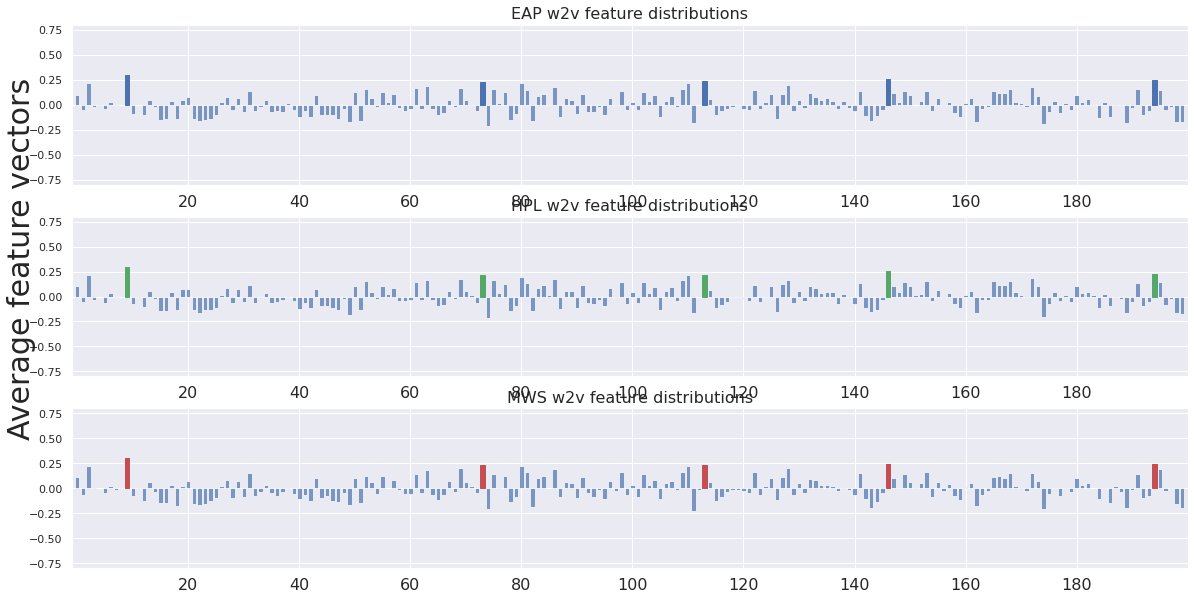

In [93]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("EAP w2v feature distributions", fontsize=16)
ax2.set_title("HPL w2v feature distributions", fontsize=16)
ax3.set_title("MWS w2v feature distributions", fontsize=16)
ax3.text(-10, 2.3, "Average feature vectors", fontsize=30, ha="center", va="center", rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3], [EAP_w2v_distribution,HPL_w2v_distribution,MWS_w2v_distribution], ['b','g','r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 200)
    ax.set_xticks(range(20,199,20))
    ax.set_xticklabels(range(20,199,20), fontsize=16)
    ax.set_ylim(-0.8,0.8)

fig.tight_layout(h_pad=3.)

Clearly this doesn't look too promising haha, but we'll give it a go!

## Classification and hyperparameters tuning

## Classification and hyperparameter tuning

We have come far now! At this point we transformed the documents we had into features we can use to train our final models. We used LDA and Word2Vec to extract sensible feature data from the documents. Now we're going to apply a few supervised classifiers to be able to predict what text belongs to which writer.

Before we start classifying, we have to transform our author labels (EAP, HPL and MWS) into numbers. We can do this with the sklearn LabelEncoder. After that we'll create a function with which we can easily train and test our models.

In [0]:
label_encoder = LabelEncoder()

label_encoder.fit(train_data.author)
train_data['author_id'] = label_encoder.transform(train_data.author)

In [0]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search
        combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model
    # (since the evaluation is based on the logloss,
    # we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model,
                           param_grid=param_grid,
                           scoring=['neg_log_loss', 'accuracy'],
                           refit = 'neg_log_loss',
                           cv=nr_folds,
                           n_jobs=-1,
                           verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    
    #show_columns = ['mean_test_score',  'rank_test_score'] #'mean_train_score',
    #for col in result_df.columns:
    #    if col.startswith('param_'):
    #        show_columns.append(col)
    #display(result_df[show_columns].sort_values(by='rank_test_score').head())
    
    display(result_df.head())
    return best_model
    

In [0]:
# since train_data['lda_features'] and train_data['w2v_features'] don't have the needed shape and type yet,
# we first have to transform every entry
X_train_lda = np.array(list(map(np.array, train_data.lda_features)))
X_train_w2v = np.array(list(map(np.array, train_data.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

Note: since we are dealing with log loss and not simply accuracy, we have to choose models that support the method predict_proba. If you're interested in what classifiers in the sklearn package support this method, you can execute the next cell.

In [110]:
from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NoSampleWeightWrapper
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
StackingClassifier
VotingClassifier
_BinaryGaussianProcessClassifierLaplace
_ConstantPredictor


## Logistic Regression

In [0]:
# store all models in a dictionary
models = dict()

In [128]:
# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, train_data.author_id)

models['best_lr_lda'] = best_lr_lda

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.012157,0.003049,0.000000,0.000000,l1,{'penalty': 'l1'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,1.587301,0.159010,0.011495,0.001602,l2,{'penalty': 'l2'},-0.959598,-0.968202,-0.956906,-0.948934,-0.946038,-0.955936,0.007897,1,0.538304,0.529111,0.537794,0.557201,0.550447,0.542572,0.009983,1


In [114]:
# Word2Vec features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v, train_data.author_id)

models['best_lr_w2v'] = best_lr_w2v

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,mean_test_score,rank_test_score,param_penalty
1,-0.673146,1,l2
0,NaN,2,l1


In [115]:
# LDA and Word2Vec combined
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_combined = get_cross_validated_model(lr, param_grid, X_train_combined, train_data.author_id)

models['best_lr_combined'] = best_lr_combined

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,mean_test_score,rank_test_score,param_penalty
1,-0.653439,1,l2
0,NaN,2,l1


In [118]:
from sklearn.ensemble import AdaBoostClassifier

mnb = AdaBoostClassifier()

param_grid = {'learning_rate': [0, 0.5, 1.0], 'n_estimators':[10, 50]}

best_mnb_combined = get_cross_validated_model(mnb, param_grid, X_train_combined, train_data.author_id)

models['best_mnb_combined'] = best_mnb_combined

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.9min finished


,mean_test_score,rank_test_score,param_learning_rate,param_n_estimators
2,-1.013436,1,0.5,10
4,-1.032744,2,1,10
3,-1.064192,3,0.5,50
5,-1.077291,4,1,50
0,NaN,5,0,10


First of all, I'm actually surprised the word2vec features perform so well! But more importantly, combining the two features gives us the best performance :D

# 4) Model Selection

Awesome! We've come to the last step. So now we've trained a coupe of models and stored them all in the 'models' variable. I think this is a great and very easy approach to finding the best model. I just sort of randomly logistic regression for this kernel, but we could have tried out other models as well!

Now let's get clear what model performed best.

In [119]:
models

{'best_lr_combined': GridSearchCV(cv=5, error_score=nan,
              estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                           fit_intercept=True,
                                           intercept_scaling=1, l1_ratio=None,
                                           max_iter=100, multi_class='auto',
                                           n_jobs=None, penalty='l2',
                                           random_state=None, solver='lbfgs',
                                           tol=0.0001, verbose=0,
                                           warm_start=False),
              iid='deprecated', n_jobs=-1, param_grid={'penalty': ['l1', 'l2']},
              pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
              scoring='neg_log_loss', verbose=True),
 'best_lr_lda': GridSearchCV(cv=5, error_score=nan,
              estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                       

In [116]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_lr_lda has a test score of: -0.9559
Model best_lr_w2v has a test score of: -0.6731
Model best_lr_combined has a test score of: -0.6534


## Make a submission

In [0]:
test_data = pd.read_csv(os.path.join(dir_path, 'test.csv'))

print(test_data.shape)
test_data.head(3)

non_ascii_words = remove_ascii_words(test_data)

print("Replaced {} words with characters with an ordinal >= 128 in the test data.".format(
    len(non_ascii_words)))

Let's repeat our preprocessing steps now. Luckily, we made a nice function that does everything for us now.

In [0]:
lda_preprocessing(test_data)
w2v_preprocessing(test_data)

In [133]:
test_data['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(LDAmodel, doc),
                                     test_data.bow))

test_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     test_data.tokenized_sentences))

train_data['author_id'] = label_encoder.transform(train_data.author)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [0]:
X_test_lda = np.array(list(map(np.array, test_data.lda_features)))
X_test_w2v = np.array(list(map(np.array, test_data.w2v_features)))
X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

Now it's time to make the classifications.

In [0]:
submission_predictions = best_lr_combined.predict_proba(X_test_combined)
label_encoder.classes_
# exactly the order in which we need to submit the writers

result = np.append(test_data.id.values.reshape(-1,1), submission_predictions, axis=1)
submission_df = pd.DataFrame(data=result, columns=['id', 'EAP', 'HPL', 'MWS'])
submission_df.to_csv(os.path.join(dir_path, 'submission.csv'), index=False)


